# Figures Notebook

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [1]:
from __future__ import division # For Python 2 compatibility
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import seaborn as sns
#%matplotlib notebook

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = 'data_exp_zs_20210105_g3_zinser-53fg.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

# write out generated plots
save_plots = True

## Load Data

In [3]:
ground_truth = {}
with nc4.Dataset('data/zinser_abundance_division_loss.nc') as nc:
    for var in nc.variables:
        ground_truth[var] = nc.variables[var][:]

try:
    zinser_fig3 = pd.read_csv('data/Zinser_figure3.csv')
except:
    zinser_fig3 = pd.read_csv('data/Zinser_Figure3.csv')

In [4]:
# load data
datafiles = {
#     'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day2.nc',
    'zinser':'data/Zinser_SizeDist_logtransform-27-8.nc',
}

# itestfiles = {
#     'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
#     'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
# }

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded[dataname]:
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    elif 'abundance' in data_gridded[dataname]:
        logging.warning('{}: Using "abundance" data to generate count data for the model.'.format(dataname))
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafiles[dataname]))
        
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

## Process Data

In [5]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

zinser: limit_days is set to 2, removing 1/25 observation times


## Model List

In [6]:
# desc_model = {
#     #'m1':'m1',
#     'm2':'m2',
#     #'m3':'m3',
#     'm4':'m4',
#     #'m5':'m5',
#     #'m6':'m6',
#     #'m7':'m7',
#     #'m8':'m8',
#     #'m9':'m9',
#     #'m10':'m10',
#     #'m11':'m11',
#     #'m12':'m12',
#     #'m13':'m13',
#     #'m14':'m14',
#     #'m3u':'m3u',
#     #'m6u':'m6u',
#     #'m7u':'m7u',
#     #'m8u':'m8u',
#     #'m9u':'m9u',
#     #'m11u':'m11u',
#     'm12u':'m12u',
#     #'m13u':'m13u',
#     #'m14u':'m14u',
#     'm15':'m15',
#     'm16':'m16',
#     'm4s6':'m4 + spline6',
#     'm12us6':'m12u + spline6',
#     'm15s6':'m15 + spline6',
#     'm16s6':'m16 + spline6',
# }
desc_model = {
    'm1':'m$_\mathrm{bfx}$', 
    'm2':'m$_\mathrm{bmx}$', 
    'm3':'m$_\mathrm{emx}$', 
    'm4':'m$_\mathrm{bmb}$', 
    'm5':'m$_\mathrm{bmb–}$', # using en-dash here
    'm6':'m$_\mathrm{eme–}$', 
    'm7':'m$_\mathrm{eme}$', 
    'm8':'m$_\mathrm{ele–}$', 
    'm9':'m$_\mathrm{ele}$', 
    'm10':'m$_\mathrm{blb–}$', 
    'm11':'m$_\mathrm{emb–}$', 
    'm12':'m$_\mathrm{emb}$', 
    'm13':'m$_\mathrm{elb–}$',
    'm14':'m$_\mathrm{elb}$',
    'm3u':'m$_\mathrm{pmx}$', 
    'm6u':'m$_\mathrm{pmp–}$', 
    'm7u':'m$_\mathrm{pmp}$', 
    'm8u':'m$_\mathrm{plp–}$', 
    'm9u':'m$_\mathrm{plp}$', 
    'm11u':'m$_\mathrm{pmb–}$', 
    'm12u':'m$_\mathrm{pmb}$', 
    'm13u':'m$_\mathrm{plb–}$',
    'm14u':'m$_\mathrm{plb}$',
    'm15':'m$_\mathrm{fmb}$',
    'm16':'m$_\mathrm{fmf}$',
    'm4s6':'m$_\mathrm{btb}$', 
    'm12us6':'m$_\mathrm{ptb}$', 
    'm15s6':'m$_\mathrm{ftb}$',
    'm16s6':'m$_\mathrm{ftf}$',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
    'm3u':(),
    'm6u':(),
    'm7u':(),
    'm8u':(),
    'm9u':(),
    'm11u':(),
    'm12u':(),
    'm13u':(),
    'm14u':(),
    'm15':(),
    'm16':(),
    'm4s6':(('^( *int nknots = *)','6;'),),
    'm12us6':(('^( *int nknots = *)','6;'),),
    'm15s6':(('^( *int nknots = *)','6;'),),
    'm16s6':(('^( *int nknots = *)','6;'),),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c11',
    'm12':'c12',
    'm13':'c13',
    'm14':'c14',
    'm3u':'c3u',
    'm6u':'c6u',
    'm7u':'c7u',
    'm8u':'c8u',
    'm9u':'c9u',
    'm11u':'c11u',
    'm12u':'c12u',
    'm13u':'c13u',
    'm14u':'c14u',
    'm15':'c15',
    'm16':'c16',
    'm4s6':'c4s',
    'm12us6':'c12us',
    'm15s6':'c15s',
    'm16s6':'c16s',
}
stan_files = {
    'c1':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowthvol_xval2.stan',
    'c2':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowthvol_xval2.stan',
    'c3':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c4':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowthvol_xval2.stan',
    'c5':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowthvol_xval2.stan',
    'c6':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c7':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c8':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c9':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c10':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowthvol_xval2.stan',
    'c11':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c12':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c13':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c14':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c3u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c6u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c7u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c8u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c9u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c11u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c12u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c13u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c14u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c15':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c16':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_freeresp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c4s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_respv1_normparam_trackgrowthvol_xval2.stan',
    'c12us':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c15s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_resp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c16s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_freeresp_freegamma_normparam_trackgrowthvol_xval2.stan',
}

## Load Results

In [7]:
load = True  # change to True if you want to load models
if load:
    mcmcs = {}
    with nc4.Dataset(savename_output) as nc:
        datafiles = nc.groups.keys()
        for dataname in datafiles:
            models = nc[dataname].groups.keys()
            for name in models:
                # Loop is structured weirdly because the hierarchy of model output
                # and saved results is reversed
                if name not in mcmcs.keys():
                    mcmcs[name] = {}
                if dataname not in mcmcs[name].keys():
                    mcmcs[name][dataname] = {}
                for var in nc[dataname][name].variables:
                    mcmcs[name][dataname][var] = nc[dataname][name].variables[var][:]

## Some Plotting Parameters

In [8]:
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['figure.figsize'] = (7.5,7.5)
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# set the color for each model
mod_list = ['m2', 'm4', 'm12u', 'm15', 'm16', 'm4s6', 'm12us6', 'm15s6', 'm16s6']
# colors_model = {model_name:mpl.cm.plasma_r((imodel+1)/(len(mod_list)))
#                 for imodel, model_name in enumerate(mod_list)}
# colors_model = {model_name: sns.color_palette('colorblind')[imodel]
#                 for imodel, model_name in enumerate(mod_list)}
color_palette = [(51/255, 24/255, 136/255), (136/255, 204/255, 238/255), (68/255, 170/255, 153/255), (17/255, 119/255, 51/255), (153/255, 153/255, 51/255), (221/255, 204/255, 119/255), (204/255, 102/255, 119/255), (136/255, 34/255, 85/255), (170/255, 68/255, 153/255)]
colors_model = {model_name: color_palette[imodel]
                for imodel, model_name in enumerate(mod_list)}

# maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

# Figures

In [9]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 36

if show_data:
    for i,dataname in enumerate(data_gridded):
        if 'zinser' in dataname:
            
            v_min = data_gridded[dataname]['v_min']
            delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v)
            v_carbon = v*np.sqrt(2**(delta_v))

### Figure 3

The idea behind this figure is to show the model inference on the "big picture" daily population dynamics. We also show PSIS-LOO scores as a metric that balances model fit with model complexity. The green vertical lines indicate the "true" values of each daily quantity calculated from the data.

TODO: Add additional lines to indicate model results for current version of MPM as a baseline for comparison. Potentially also add Ek and model misfit.

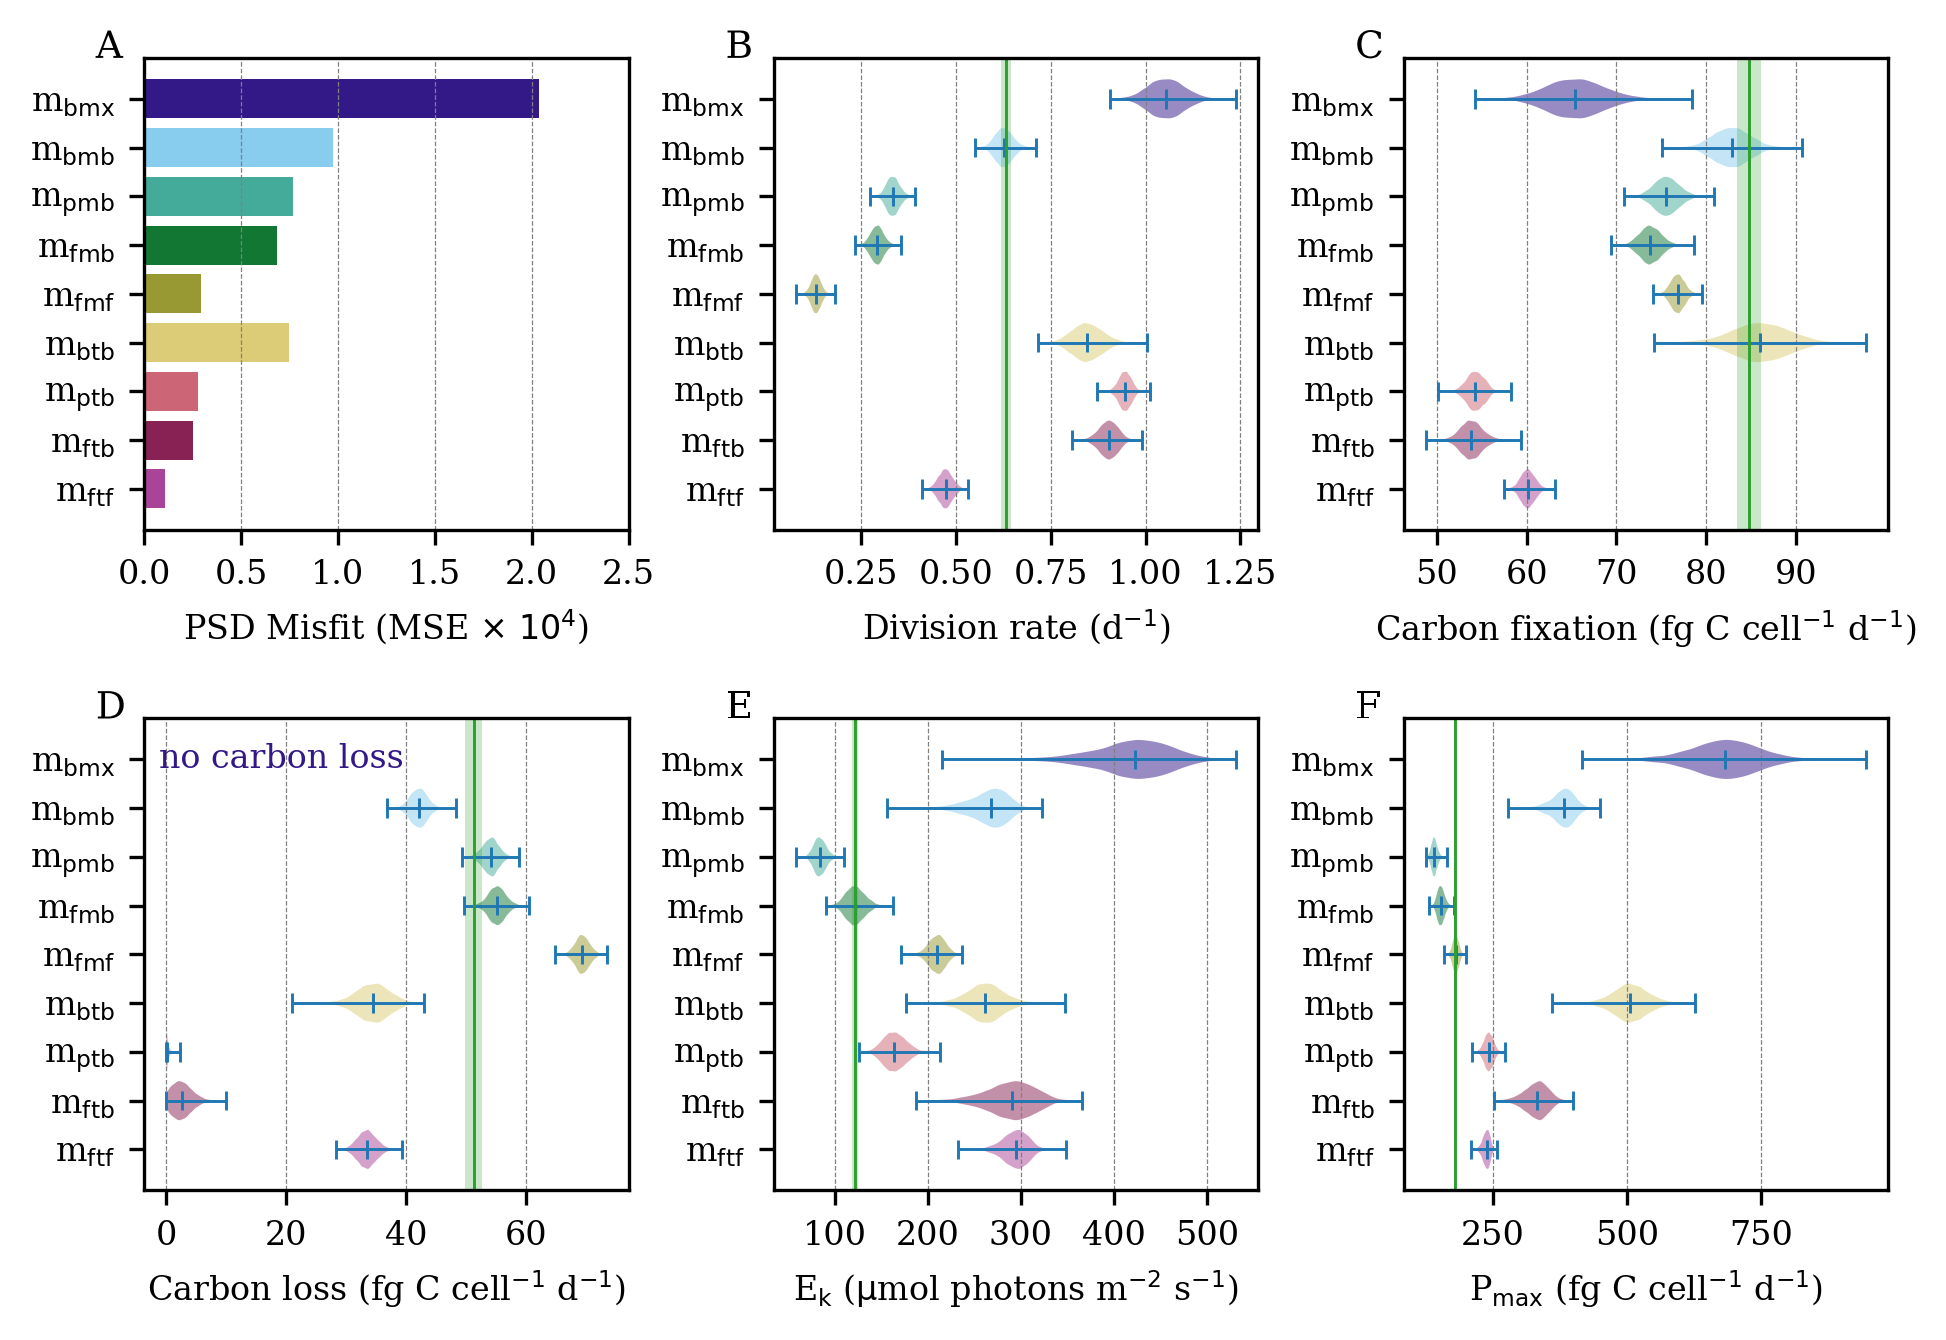

In [10]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9

xtext = -0.1
ytext = 1
text_color = 'black'

truth_lw = 0.7
truth_alpha = 0.25
truth_color = 'tab:green'
widths = 0.8
linewidth = 0.7
violin_alpha = 0.5

show_grid = True
grid_width = 0.3
which_grid = 'both'
grid_axis = 'x'
grid_color = 'grey'
grid_style = '--'

for dataname in ['zinser']:
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs}
    num_mcmcs = len(temp_mcmcs)
    fig, axs = plt.subplots(2, 3, figsize=(7.5,5))
    
    
    # PSD misfit (MSE)
    ax = axs[0, 0]
    obs = data[dataname]['obs']
    num_bars = 1
    ee = np.zeros(len(temp_mcmcs))
    yticks = []
    yticklabels = []
    for ii, model in enumerate(temp_mcmcs):
        mod_mean = np.mean(temp_mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        ee[ii] = np.mean((mod_mean-obs)**2)

    ax.barh(y=np.arange(len(temp_mcmcs)), width=ee*10000, color=[colors_model[model] for model in temp_mcmcs])
    ax.invert_yaxis()
    ax.text(xtext, ytext, 'A', transform=ax.transAxes, color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.set(yticks=np.arange(0, num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xticks=np.linspace(0, 2.5, num=6))
    ax.set_xlabel(r'PSD Misfit (MSE $\times ~ 10^4$)')
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    
    
    # Daily division rates
    ax = axs[0, 1]
    plot = ax.violinplot([temp_mcmcs[model][dataname]['divrate'] for model in temp_mcmcs],
                         showmedians=True, vert=False, widths=widths)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(violin_alpha)
        ii += 1
    ax.invert_yaxis()
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='Division rate (d$^{-1}$)')
    ax.set_xticks(np.linspace(0, 1.25, num=6), minor=False)
#     ax.set_xticks(np.linspace(0.25, 1.25, num=3), minor=True)
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    if 'zinser' in dataname:
        ax.axvline(ground_truth['dailydivision'], color=truth_color, lw=truth_lw)
        ax.axvspan(ground_truth['dailydivision']-ground_truth['dailydivision_sd'],
                   ground_truth['dailydivision']+ground_truth['dailydivision_sd'],
                   facecolor='tab:green', alpha=truth_alpha)
    ax.text(xtext, ytext, 'B', transform = ax.transAxes, color=text_color,
            fontsize=fontsize, path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    
    
    # Daily growth/respiration
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    daily_props = {}

    for prop in ['growth', 'respiration']:

        daily_props[prop] = {}

        for model in temp_mcmcs:

            cell_count = temp_mcmcs[model][dataname]['cell_count']

            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))

            daily_prop = np.mean(plotprop, axis=1)*24

            daily_props[prop][model] = daily_prop
            
    xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                  'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}
    labels = {'growth': 'C', 'respiration': 'D'}
    par_string = {'growth': 'carbonfix', 'respiration': 'carbonloss'}

    for ax, prop in zip((axs[0, 2], axs[1, 0]), ('growth', 'respiration')):
        
        if prop == 'respiration':
            plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop] if model != 'm2'],
                                 showmedians=True, vert=False, widths=widths)
        else:
            plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                                 showmedians=True, vert=False, widths=widths)
        ii = 0
        if prop == 'respiration':
             colors = [colors_model[model] for model in temp_mcmcs if model != 'm2']
        else:
            colors = [colors_model[model] for model in temp_mcmcs]
        for pc in plot['bodies']:
            pc.set_facecolor(colors[ii])
            pc.set_alpha(violin_alpha)
            ii += 1
        ax.set(yticks=np.arange(1, num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
               xlabel=xlabels[prop])
        if prop == 'respiration':
            ax.set_ylim(-0.84, 8.84)
            ax.set_yticks(np.arange(0, num_mcmcs))
            ax.text(0.03, 0.895, 'no carbon loss', transform = ax.transAxes, color=colors_model['m2'], fontsize=8)
        ax.invert_yaxis()
        if prop == 'growth':
            ax.set_xticks(np.linspace(50, 90, num=5))
        elif prop == 'respiration':
            ax.set_xticks(np.linspace(0, 60, num=4))
        plot['cbars'].set_linewidth(linewidth)
        plot['cmins'].set_linewidth(linewidth)
        plot['cmaxes'].set_linewidth(linewidth)
        plot['cmedians'].set_linewidth(linewidth)
        if 'zinser' in dataname:
            ax.axvline(ground_truth['daily'+par_string[prop]], color=truth_color, lw=truth_lw)
            ax.axvspan(ground_truth['daily'+par_string[prop]]-ground_truth['daily'+par_string[prop]+'_sd'],
                       ground_truth['daily'+par_string[prop]]+ground_truth['daily'+par_string[prop]+'_sd'],
                       facecolor='tab:green', alpha=truth_alpha)
        ax.text(xtext, ytext, labels[prop], transform = ax.transAxes, color=text_color, fontsize=fontsize,
                path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
        ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    
    
    # Ek/Estar
    ax = axs[1, 1]
    linewidth = 0.7
    plot = ax.violinplot([temp_mcmcs[model][dataname]['E_star'] for model in temp_mcmcs],
                         showmedians=True, vert=False, widths=0.8)
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='E$_\mathrm{k}$ ($\mathrm{\mu}$mol photons m$^{-2}$ s$^{-1}$)')
    ax.set_xticks(np.linspace(100, 500, num=5), minor=False)
    true_Estar = np.mean(np.asarray(zinser_fig3['Estar']))
    Estar_sd = np.sqrt(np.sum(np.asarray(zinser_fig3['Estar-sd'])**2)
                       / (np.asarray(zinser_fig3['Estar-sd']).shape[0]**2))
    ax.axvline(true_Estar, color=truth_color, lw=truth_lw)
    ax.axvspan(true_Estar-Estar_sd, true_Estar+Estar_sd, facecolor=truth_color, alpha=truth_alpha)
    
    ax.text(xtext, ytext, 'E', transform = ax.transAxes, color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    
    
    # Pmax
    ax = axs[1, 2]
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    linewidth = 0.7
    pmax = [np.mean(temp_mcmcs[model][dataname]['max_size_gain']/cell_count/dt_h, axis=1)*24
            for model in temp_mcmcs]
    
    plot = ax.violinplot(pmax, showmedians=True, vert=False, widths=0.8)
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='P$_\max$ (fg C cell$^{-1}$ d$^{-1}$)')
    
    true_pmax = np.mean(np.asarray(zinser_fig3['Pmax']))*24
    pmax_sd = np.sqrt(np.sum(np.asarray(zinser_fig3['Pmax-sd'])**2))
    ax.axvline(true_pmax, color=truth_color, lw=truth_lw)
    ax.axvspan(true_pmax-pmax_sd, true_pmax+pmax_sd, facecolor=truth_color, alpha=truth_alpha)
    
    ax.text(xtext, ytext, 'F', transform = ax.transAxes, color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    

    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    warnings.filterwarnings("ignore")
    if save_plots:
        plt.savefig('figures_test/zinser_daily.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

### Figure 4

The idea of this figure is to look further under the hood of the model, and see what the model parameters are applying is happening on an hourly time scale. This reveals that the model has limitations on high-resolution time scales, most notably the lag in the timing of peak division.

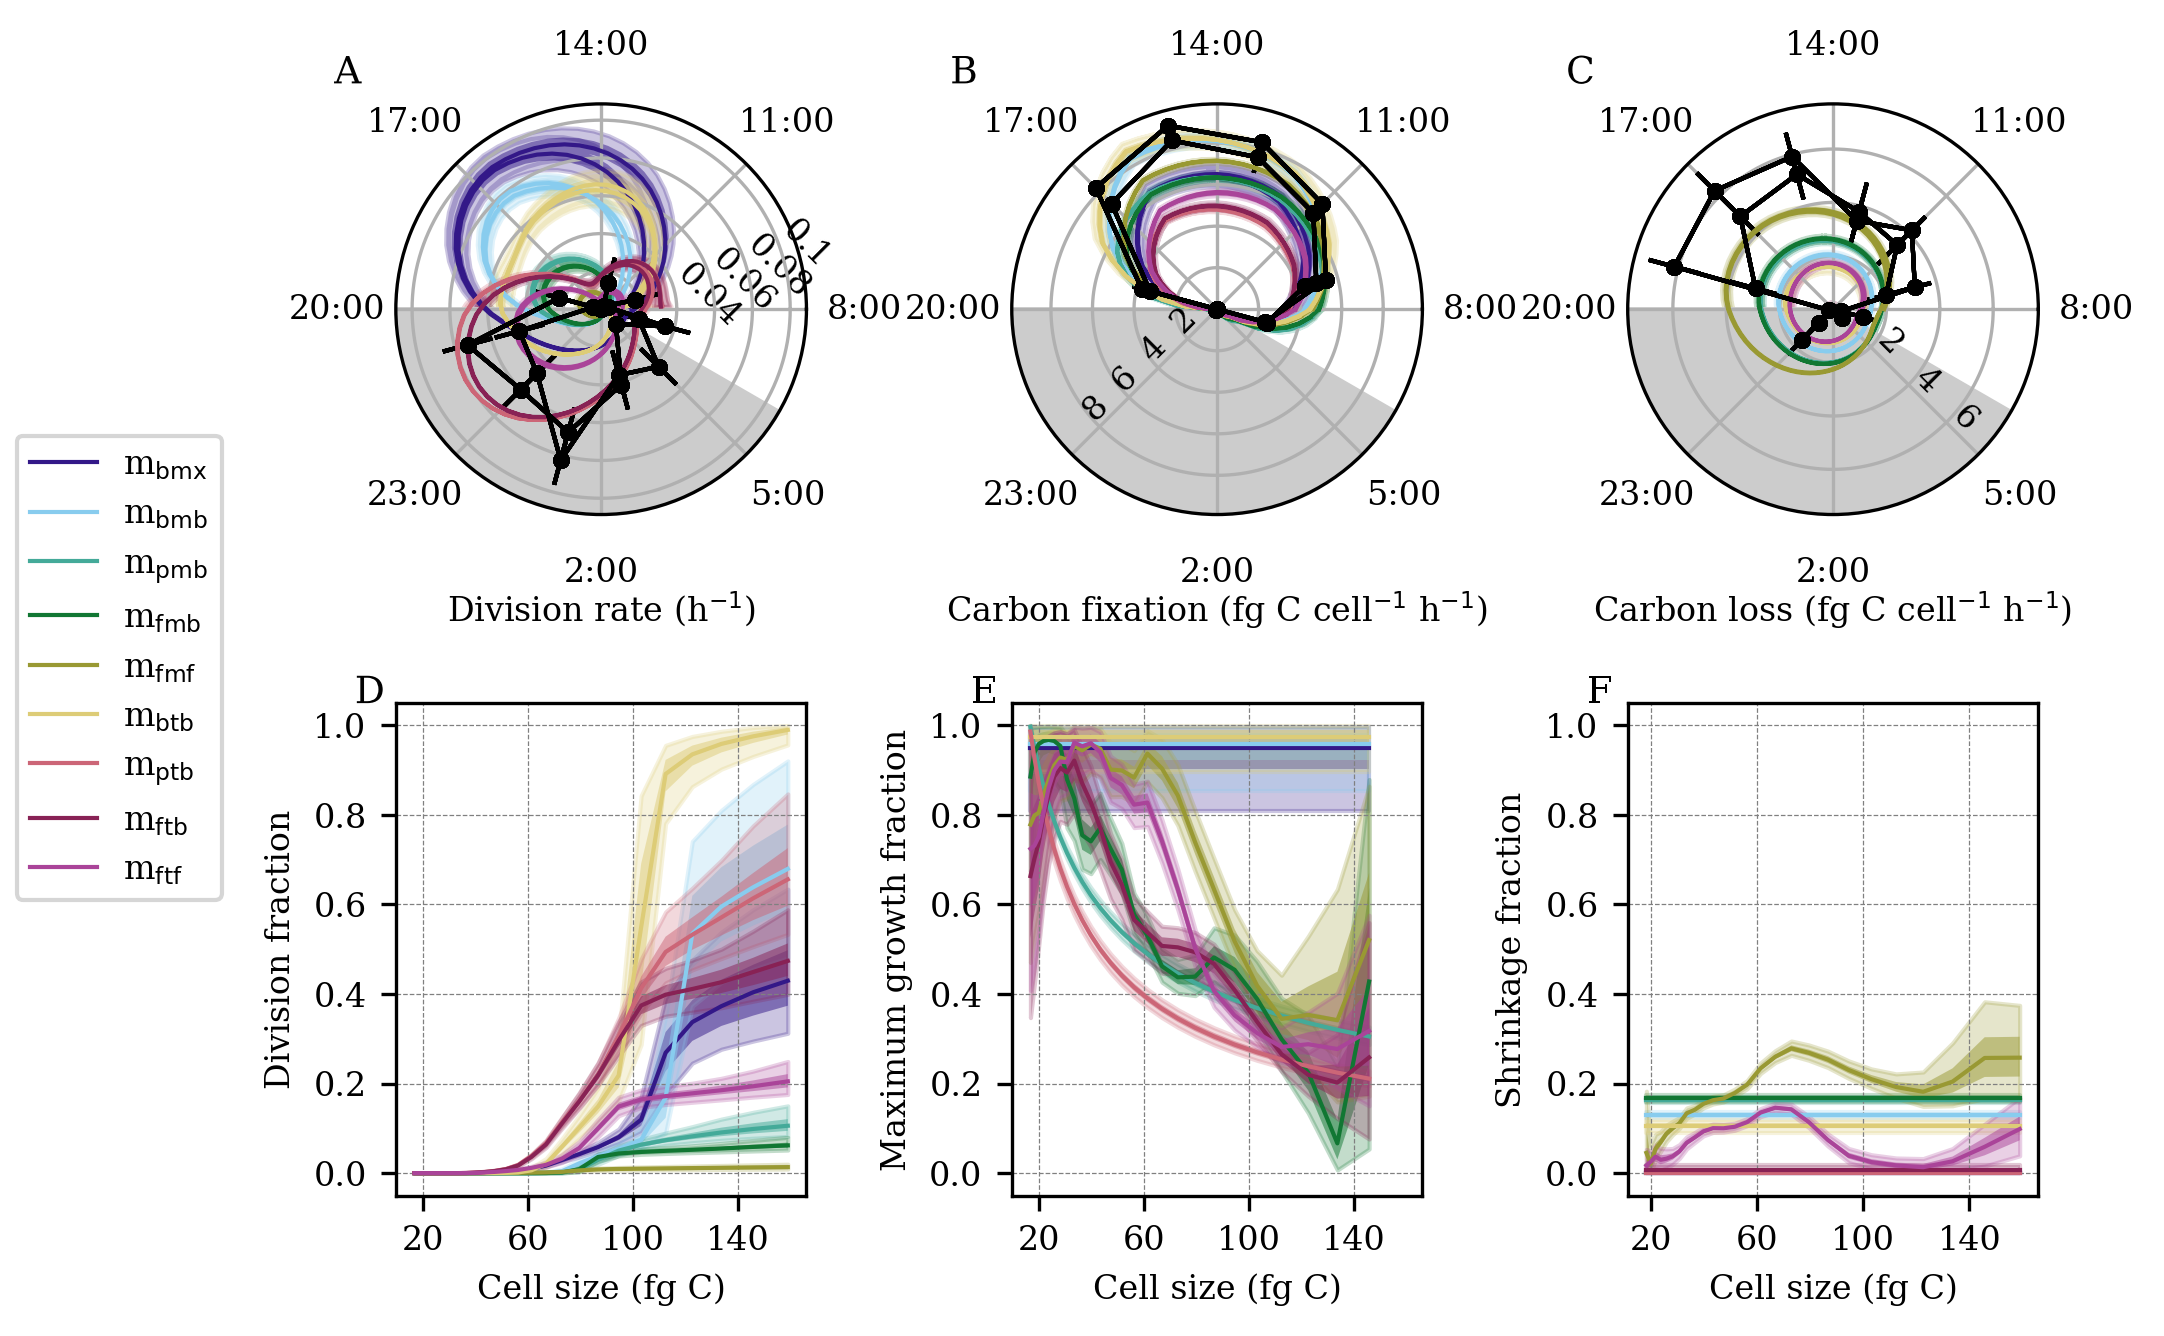

In [11]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'Carbon fixation ({} h$^{{-1}}$)'.format(size_units),
    'division':'Division rate (h$^{-1}$)',
    'respiration':'Carbon loss ({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9
label_fontsize = 8

show_grid = True
grid_width = 0.3
which_grid = 'major'
grid_axis = 'both'
grid_color = 'grey'
grid_style = '--'

xtext = -0.1
ytext = 1

xtext_pol = -0.15
ytext_pol = 1.05

text_color = 'black'

for dataname in ['zinser']:
    fig = plt.figure(figsize=(7.5, 5))
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs}
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    
    grids = gridspec.GridSpec(2, 1, figure=fig)
    
    
    # Hourly rate plots
    polar_grid = grids[0].subgridspec(1, 3)
    
    ii = 0
    mod_maxes = {}
    labels = {'division': 'A', 'growth': 'B', 'respiration': 'C'}
    par_string_dict = {'division': 'division', 'growth': 'carbonfix', 'respiration': 'carbonloss'}
    for prop in ('division', 'growth', 'respiration'):
        ax = fig.add_subplot(polar_grid[ii], polar=True)
        par_string = par_string_dict[prop]
        
        for model in temp_mcmcs:
            cell_count = temp_mcmcs[model][dataname]['cell_count']
        
            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t * (np.pi/12.0)
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1]) * (np.pi/12.0)
                temp = np.mean(plotprop, axis=0)
                mod_max = np.where(temp == np.max(temp[0:72]))[0][0]/3
                mod_maxes[model] = mod_max
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t * (np.pi/12.0)
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
            if dataname == 'zinser':
                ax.errorbar(x=ground_truth[par_string+'_time']*(np.pi/12.0), y=ground_truth[par_string],
                           yerr=ground_truth[par_string+'_sd'], color='black', marker='o', lw=1,
                           markersize=3)
        ax.set_ylim(bottom=0.0)
        ax.set_xlabel(prop_labels[prop], labelpad=0)
        ax.set_xticklabels(['{:d}:{:02d}'.format((int(t*(12/np.pi)+8)%24), int(60*(t*(12/np.pi)%1.0)))
                            for t in ax.get_xticks()])
        # darkness from 20:00 to 6:00
        # ymax > 1 needed because it's a polar plot
        ax.axvspan(720*(np.pi/720.0), (1440-120)*(np.pi/720.0), color='0.8', ymax=10, zorder=1)
        ax.grid(True)
        if prop == 'growth':
            ax.set_rlabel_position(-135)
            ax.tick_params(axis='y', labelrotation=45)
        elif prop == 'respiration':
            ax.set_rlabel_position(-45)
            ax.tick_params(axis='y', labelrotation=-45)
        elif prop == 'division':
            ax.tick_params(axis='y', labelrotation=-45)
            yticks = ax.get_yticks()
            yticks_new = [str(np.round(yticks[ii], 2)) if ii > 0 else '' for ii in range(len(yticks))]
            ax.set_yticklabels(yticks_new)
        ax.text(xtext_pol, ytext_pol, labels[prop], transform = ax.transAxes, color=text_color, fontsize=fontsize,
                path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
        ii += 1
    
    reg_grid = grids[1].subgridspec(1, 3)
    
    
    # Division vs. size
    dt_h = data[dataname]['dt']/60
    dt_days = data[dataname]['dt']/1440
    m = temp_mcmcs['m4']['zinser']['w_ini'].shape[1]
    ax = fig.add_subplot(reg_grid[0])
#     ax.set_xscale('log')
#     x = v_carbon[-(temp_mcmcs['m4']['zinser']['delta'].shape[1]):]
    x = v_carbon
#     minor_ticks = np.linspace(40, 120, 3)
    major_ticks = np.linspace(20, 140, 4)
    ax.set_xticks([], minor=True)
#     ax.set_xticklabels(['' for ii in range(len(minor_ticks))], minor=True)
#     ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticklabels([str(int(np.round(major_ticks[ii], 0))) for ii in range(len(major_ticks))], minor=False,
                       fontdict={'fontsize': label_fontsize})
    for model in temp_mcmcs:
        div_size_raw = temp_mcmcs[model][dataname]['delta'] * dt_days
        zeros = np.zeros(shape=(div_size_raw.shape[0], m-div_size_raw.shape[1]))
        div_size = np.concatenate((zeros, div_size_raw), axis=1)
        qq = np.percentile(div_size, q=(5,25,50,75,95), axis=0)
        sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
        ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
    ax.set_xlabel('Cell size (fg C)')
#     ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], loc='best', ncol=2, fontsize=8,
#               handlelength=0.8, columnspacing=0.4, labelspacing=0.3, handletextpad=0.2)
    ax.set_ylabel('Division fraction')
    ax.text(xtext, ytext, 'D', transform = ax.transAxes, color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    
    
    # Carbon fixation vs. size
    ax = fig.add_subplot(reg_grid[1])
    dt_h = data[dataname]['dt']/60
    dt_days = data[dataname]['dt']/1440
    dt_norm = dt_days / (2**(1/data_gridded[dataname]['delta_v_inv'])-1.0)
#     ax.set_xscale('log')
    x = v_carbon[:-1]
#     minor_ticks = [x[ii] for ii in range(len(x)) if ii % 5 != 2]
#     major_ticks = [x[ii] for ii in range(len(x)) if ii % 5 == 0]
#     ax.set_xticks(minor_ticks, minor=True)
#     ax.set_xticklabels(['' for ii in range(len(minor_ticks))], minor=True)
    ax.set_xticks([], minor=True)
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticklabels([str(int(np.round(major_ticks[ii], 0))) for ii in range(len(major_ticks))], minor=False,
                       fontdict={'fontsize': label_fontsize})
    ax.set(ylim=ylim, xlim=xlim)
    for model in temp_mcmcs:
        gamma_max = temp_mcmcs[model][dataname]['gamma_max']
        if len(gamma_max.shape) == 1:
            growth_size = np.tile(gamma_max, m-1).reshape(m-1, -1).T
        else:
            growth_size = gamma_max
        if 'exponent_gamma' in temp_mcmcs[model][dataname].keys():
            exponent_gamma = temp_mcmcs[model][dataname]['exponent_gamma']
            
            # No model output has a positive exponent_gamma, so we can assume negative
            sizelim_gamma = ((v_carbon[None, :-1]**exponent_gamma[:, None]) /
                             (v_carbon[None, 0]**exponent_gamma[:, None]))
            growth_size = growth_size * sizelim_gamma
        growth_size = growth_size * dt_norm

        qq = np.percentile(growth_size, q=(5,25,50,75,95), axis=0)
        sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
        ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
    ax.set_xlabel('Cell size (fg C)')
#     ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], loc='best', ncol=3, fontsize=8,
#               handlelength=0.8, columnspacing=0.4, labelspacing=0.3, handletextpad=0.2)
    ax.set_ylabel('Maximum growth fraction')
    ax.text(xtext, ytext, 'E', transform = ax.transAxes, color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    
    
    # Carbon loss vs. size
    ax = fig.add_subplot(reg_grid[2])
    dt_h = data[dataname]['dt']/60
    dt_days = data[dataname]['dt']/1440
    dt_norm = dt_days / (2**(1/data_gridded[dataname]['delta_v_inv'])-1.0)
#     ax.set_xscale('log')
    m = temp_mcmcs['m4']['zinser']['w_ini'].shape[1]
    x = v_carbon[1:]
#     minor_ticks = [x[ii] for ii in range(len(x)) if ii % 5 != 1]
#     major_ticks = [x[ii] for ii in range(len(x)) if ii % 5 == 0]
    ax.set_xticks([], minor=True)
#     ax.set_xticklabels(['' for ii in range(len(minor_ticks))], minor=True)
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticklabels([str(int(np.round(major_ticks[ii], 0))) for ii in range(len(major_ticks))], minor=False,
                       fontdict={'fontsize': label_fontsize})
    ax.set(ylim=ylim)
    for model in temp_mcmcs:
        if model == 'm2':
            rho_max = np.zeros(6000)
        else:
            rho_max = temp_mcmcs[model][dataname]['rho_max']
        if len(rho_max.shape) == 1:
            resp_size = np.tile(rho_max, m-1).reshape(m-1, -1).T
        else:
            resp_size = rho_max
        resp_size = resp_size * dt_norm
        qq = np.percentile(resp_size, q=(5,25,50,75,95), axis=0)
        sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
        ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
    ax.set_xlabel('Cell size (fg C)')
#     ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], loc='upper left', ncol=3,
#               fontsize=8, handlelength=0.8, columnspacing=0.4, labelspacing=0.3, handletextpad=0.2)
    ax.set_ylabel('Shrinkage fraction')
    ax.text(xtext, ytext, 'F', transform = ax.transAxes, color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)
    
    fig.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], ncol=1, fontsize=8, loc='center left')
    
    
    
    
    plt.subplots_adjust(hspace=0.3, wspace=0.5, left=0.17)
    warnings.filterwarnings('ignore')
    if save_plots:
        plt.savefig('figures_test/zinser_hourly.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

### data plot `fig:zinser_data`

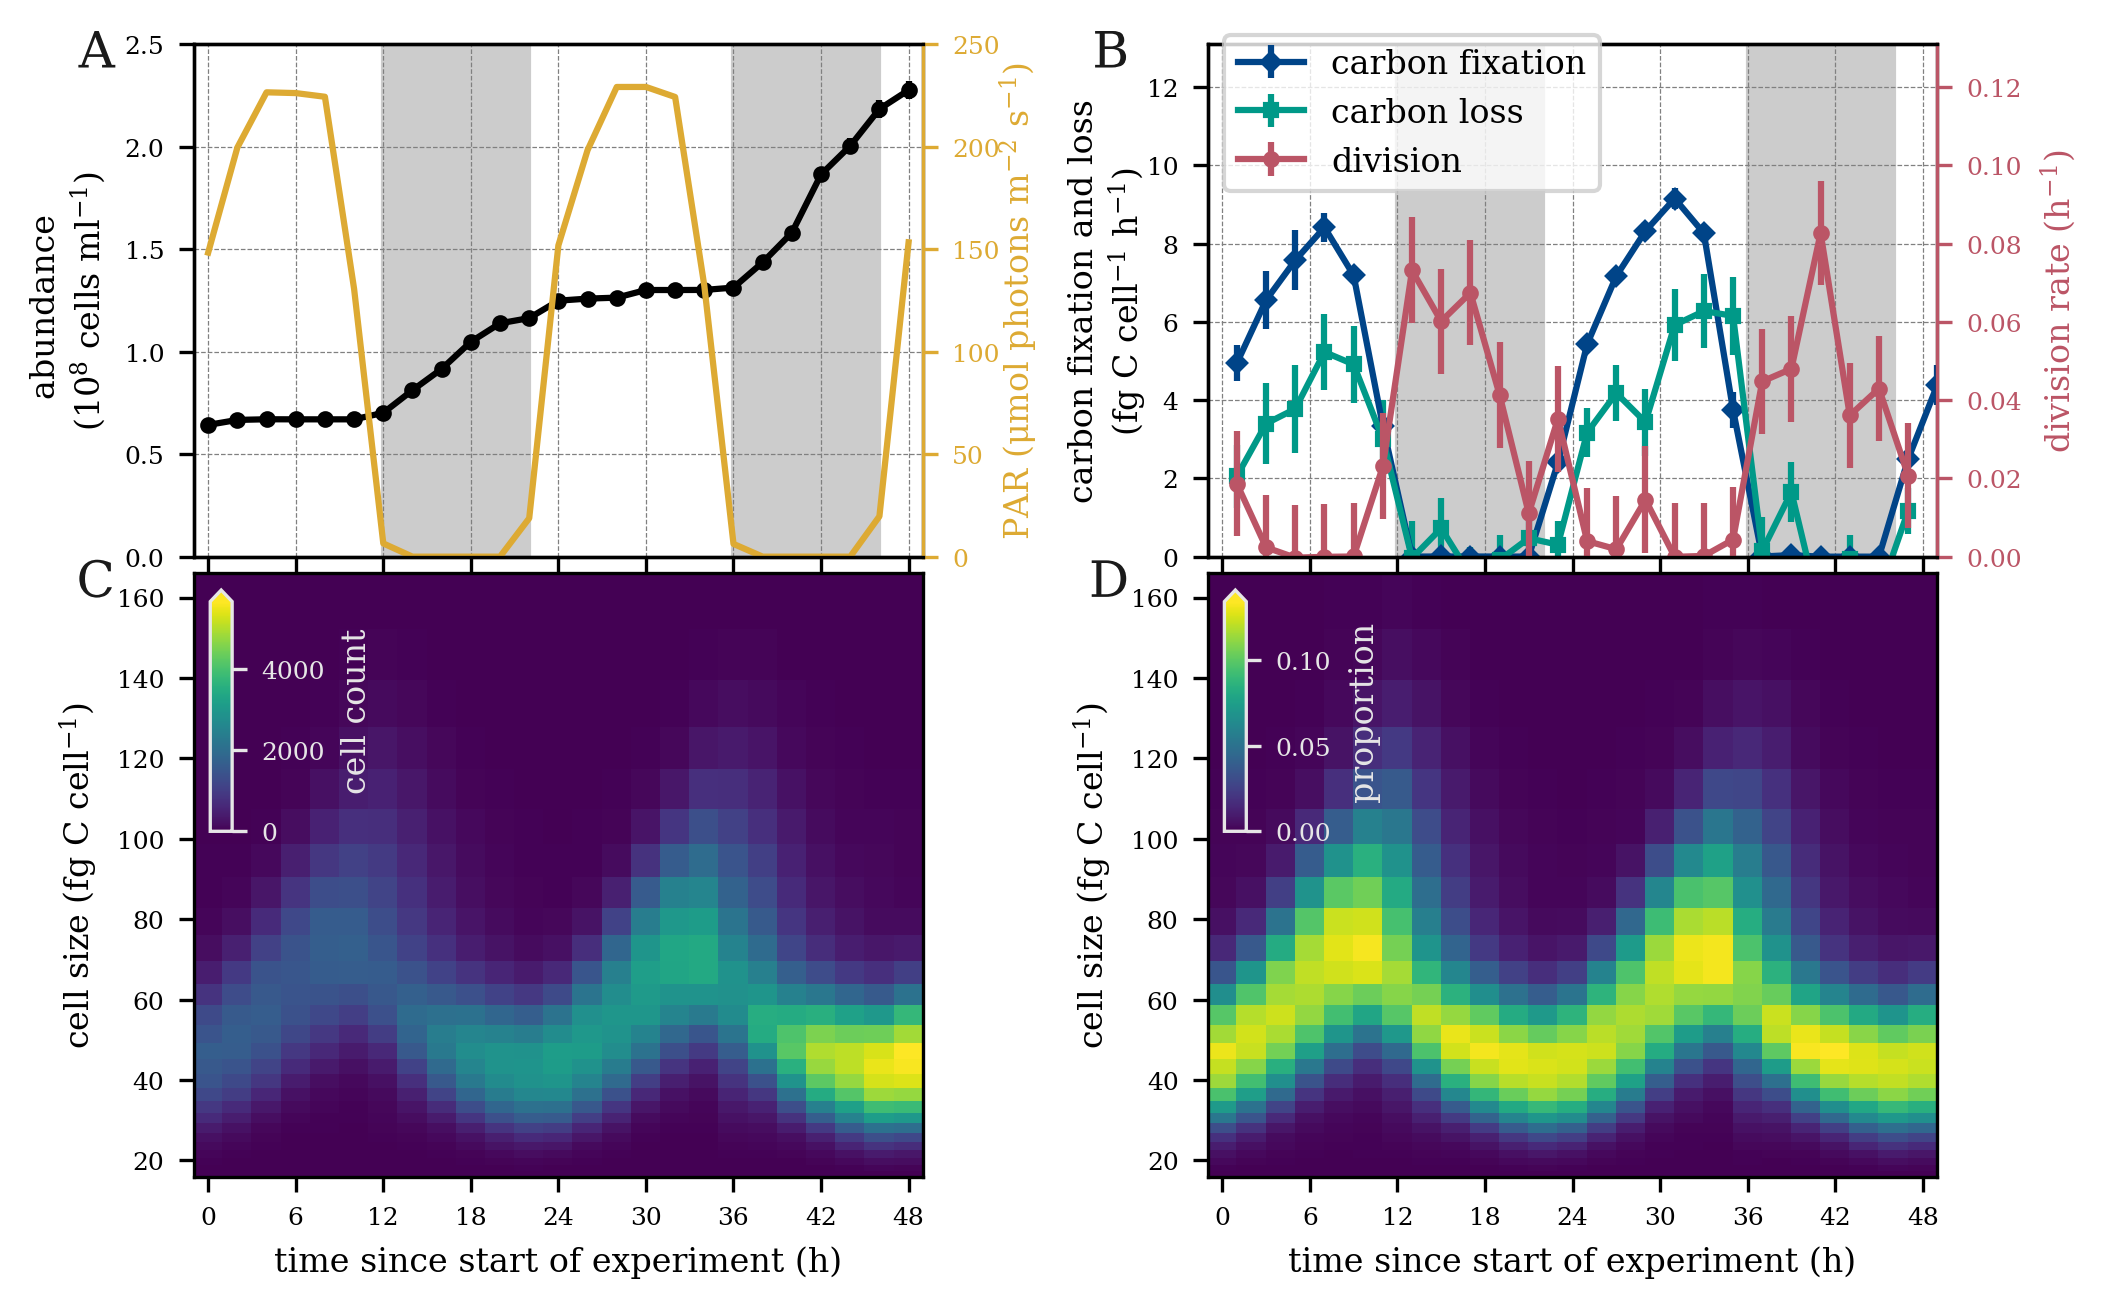

In [12]:
prop_colors = {
#     'growth':'#4477aa',
#     'division':'#aa3344',
#     'respiration':'#ccbb44',
    'growth':'#004488',
    'division':'#bb5566',
    'respiration':'#009988',
    'abundance':'black',  
    'light':'#ddaa33',    
}

prop_labels = {
    'size':'cell size (fg C cell$^{-1}$)',
    'growth':'carbon fixation (fg C cell$^{-1}$ h$^{-1}$)',
    'growthresp':'carbon fixation and loss\n(fg C cell$^{-1}$ h$^{-1}$)',
    'division':'division rate (h$^{-1}$)',
    'respiration':'carbon loss (fg C cell$^{-1}$ h$^{-1}$)',
    'abundance':'abundance (cells ml$^{-1}$)',
    'light':'PAR ($\\mu$mol photons m$^{-2}$ s$^{-1}$)',
}

size_bound_edges = v_min * 2**(np.arange(data_gridded[dataname]['m']+1)*delta_v)

t = data_gridded[dataname]['time']/60
t_edges = np.empty(t.size+1)
t_edges[1:-1] = 0.5 * (t[1:] +t[:-1])
t_edges[0] = 0.5 * (t[0] - t[1])
t_edges[-1] = t[-1] + 0.5*(t[-1]-t[-2])

mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 9
mpl.rcParams['grid.color'] = grid_color
mpl.rcParams['grid.linestyle'] = grid_style
mpl.rcParams['grid.linewidth'] = grid_width

#
# plotting
#

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 5), squeeze=False, sharex='col', 
                        gridspec_kw={'hspace':0.03, 'wspace':0.39, 'height_ratios':(1.7,2)})    

def add_colorbar(ax, label=None, labelcolor='0.9', **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='40%', loc='upper left', bbox_to_anchor=(0.0,0.0,1,1), bbox_transform=ax.transAxes)
    cb = mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)
    cb.set_label(label, color=labelcolor)
    for ytl in cb.ax.get_yticklabels():
        ytl.set_color(labelcolor)
    cb.ax.tick_params(axis='y', colors=labelcolor)
    cb.outline.set_edgecolor(labelcolor)

ax_abundance_par = axs[0,0]
ax_growthresp_div = axs[0,1]
ax_celldist = axs[1,1]
ax_cellcount = axs[1,0]

#
# pcolor
#

for iax,ax in enumerate([ax_celldist, ax_cellcount]):
    if ax is None:
        continue

    if iax == 0:
        tmp = data_gridded[dataname]['w_obs']
        label = 'proportion'
    else:
        tmp = data_gridded[dataname]['counts']
        label = 'cell count'

    norm = mpl.colors.Normalize(vmin=0.0)
    pc = ax.pcolormesh(t_edges, size_bound_edges, tmp, norm=norm, rasterized=True)

    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label=label, extend='max')
    #ax.text(0.02, 0.98, 'observations', ha='left', va='top', color='white', transform=ax.transAxes)

    ax.set_ylabel(prop_labels['size'])

#
# abundance + PAR
#

if ax_abundance_par is not None:
    ax = ax_abundance_par

    exp = 8

    prop = 'abundance'
    ax.errorbar(ground_truth['abundance_time'], ground_truth['abundance']/(10**exp), 
                yerr=ground_truth['abundance_sd']/(10**exp), color=prop_colors[prop], 
                marker='o', label='cell abundance', ms=3)

    prop = 'light'
    ax_twin = ax.twinx()
    ax_twin.plot(data_gridded[dataname]['time']/60, data_gridded[dataname]['PAR'], color=prop_colors[prop], 
                 label='PAR')

    # equalize y-grid so that ticks on both sides align
    ax.set_ylim((0.0, 2.5))
    ax_twin.set_ylim((0.0, 250))
    ax.grid(True)

    ax.set_ylabel('{1}\n(10$^{0}$ {2}'.format(exp, *prop_labels['abundance'].split('(')))
    ax_twin.set_ylabel(prop_labels[prop], color=prop_colors[prop], labelpad=-0.5)
    ax_twin.tick_params(axis='y', colors=prop_colors[prop])
    ax_twin.spines['right'].set_color(prop_colors[prop])

#
# groth + div + resp        
#

if ax_growthresp_div is not None:
    ax = ax_growthresp_div

    prop = 'growth'
    ax.errorbar(ground_truth['carbonfix_time'], ground_truth['carbonfix'], 
                yerr=ground_truth['carbonfix_sd'], color=prop_colors[prop], 
                marker='D', label=prop_labels[prop].split('(')[0].strip())

    prop = 'respiration'
    ax.errorbar(ground_truth['carbonloss_time'], ground_truth['carbonloss'],
                yerr=ground_truth['carbonloss_sd'], color=prop_colors[prop], 
                marker='s', label=prop_labels[prop].split('(')[0].strip())

    ax_twin = ax.twinx()
    prop = 'division'
    ax_twin.errorbar(ground_truth['division_time'], ground_truth['division'],
                     yerr=ground_truth['division_sd'], color=prop_colors[prop], 
                     marker='o', label='division')

    ylim = np.array((0.0, 13.1))
    ax.set_ylim(ylim)
    ax_twin.set_ylim(ylim/100)
    ax.grid(True)

    ax.set_ylabel(prop_labels['growthresp'], labelpad=-0.5)
    ax_twin.set_ylabel(prop_labels['division'], color=prop_colors[prop])
    ax_twin.tick_params(axis='y', colors=prop_colors[prop])
    ax_twin.spines['right'].set_color(prop_colors[prop])
    for ytl in ax_twin.get_yticklabels():
        ytl.set_color(prop_colors[prop])

    handles0, labels0 = ax.get_legend_handles_labels()
    handles1, labels1 = ax_twin.get_legend_handles_labels()

    ax_twin.legend((handles0[0], handles0[1], handles1[0]), (labels0[0], labels0[1], labels1[0]), 
                   loc='upper left', bbox_to_anchor=(0.0, 0.05, 1, 1))

#
# additions to plots
#

for ax in (ax_abundance_par, ax_growthresp_div):
    if ax is not None:
        for iday in range(2):
            ax.axvspan(iday*24+12, iday*24+22, color='0.8', zorder=0)

for ax in axs[-1,:]:
    ax.set_xlabel('time since start of experiment (h)')

    ax.set_xticks(np.arange(0,48+1,6))
        
    dt = t[1] - t[0]
    ax.set_xlim((t[0] - 0.5 * dt, t[-1] + 0.5 * dt))

path_effects=[pe.withStroke(linewidth=2,foreground='white',alpha=0.75)]
for iax, ax in enumerate(axs.flat):
    points = ax.get_subplotspec().get_position(fig).get_points()
    x = points[0,0] - 0.035
    y = points[1,1] + 0.01

    fig.text(x, y, 'ABCDEFG'[iax], size=12, ha='right', va='top', color='0.1', path_effects=path_effects)

if save_plots:
    plt.savefig('figures_test/zinser_data_compact.pdf', bbox_inches='tight', dpi=300)

### data plot `fig:division_vs_size`

at index  7: marking 14.0h to 16.0h
at index 17: marking 34.0h to 36.0h
index  7: averaging from 14.0h to 16.0h
index 17: averaging from 34.0h to 36.0h


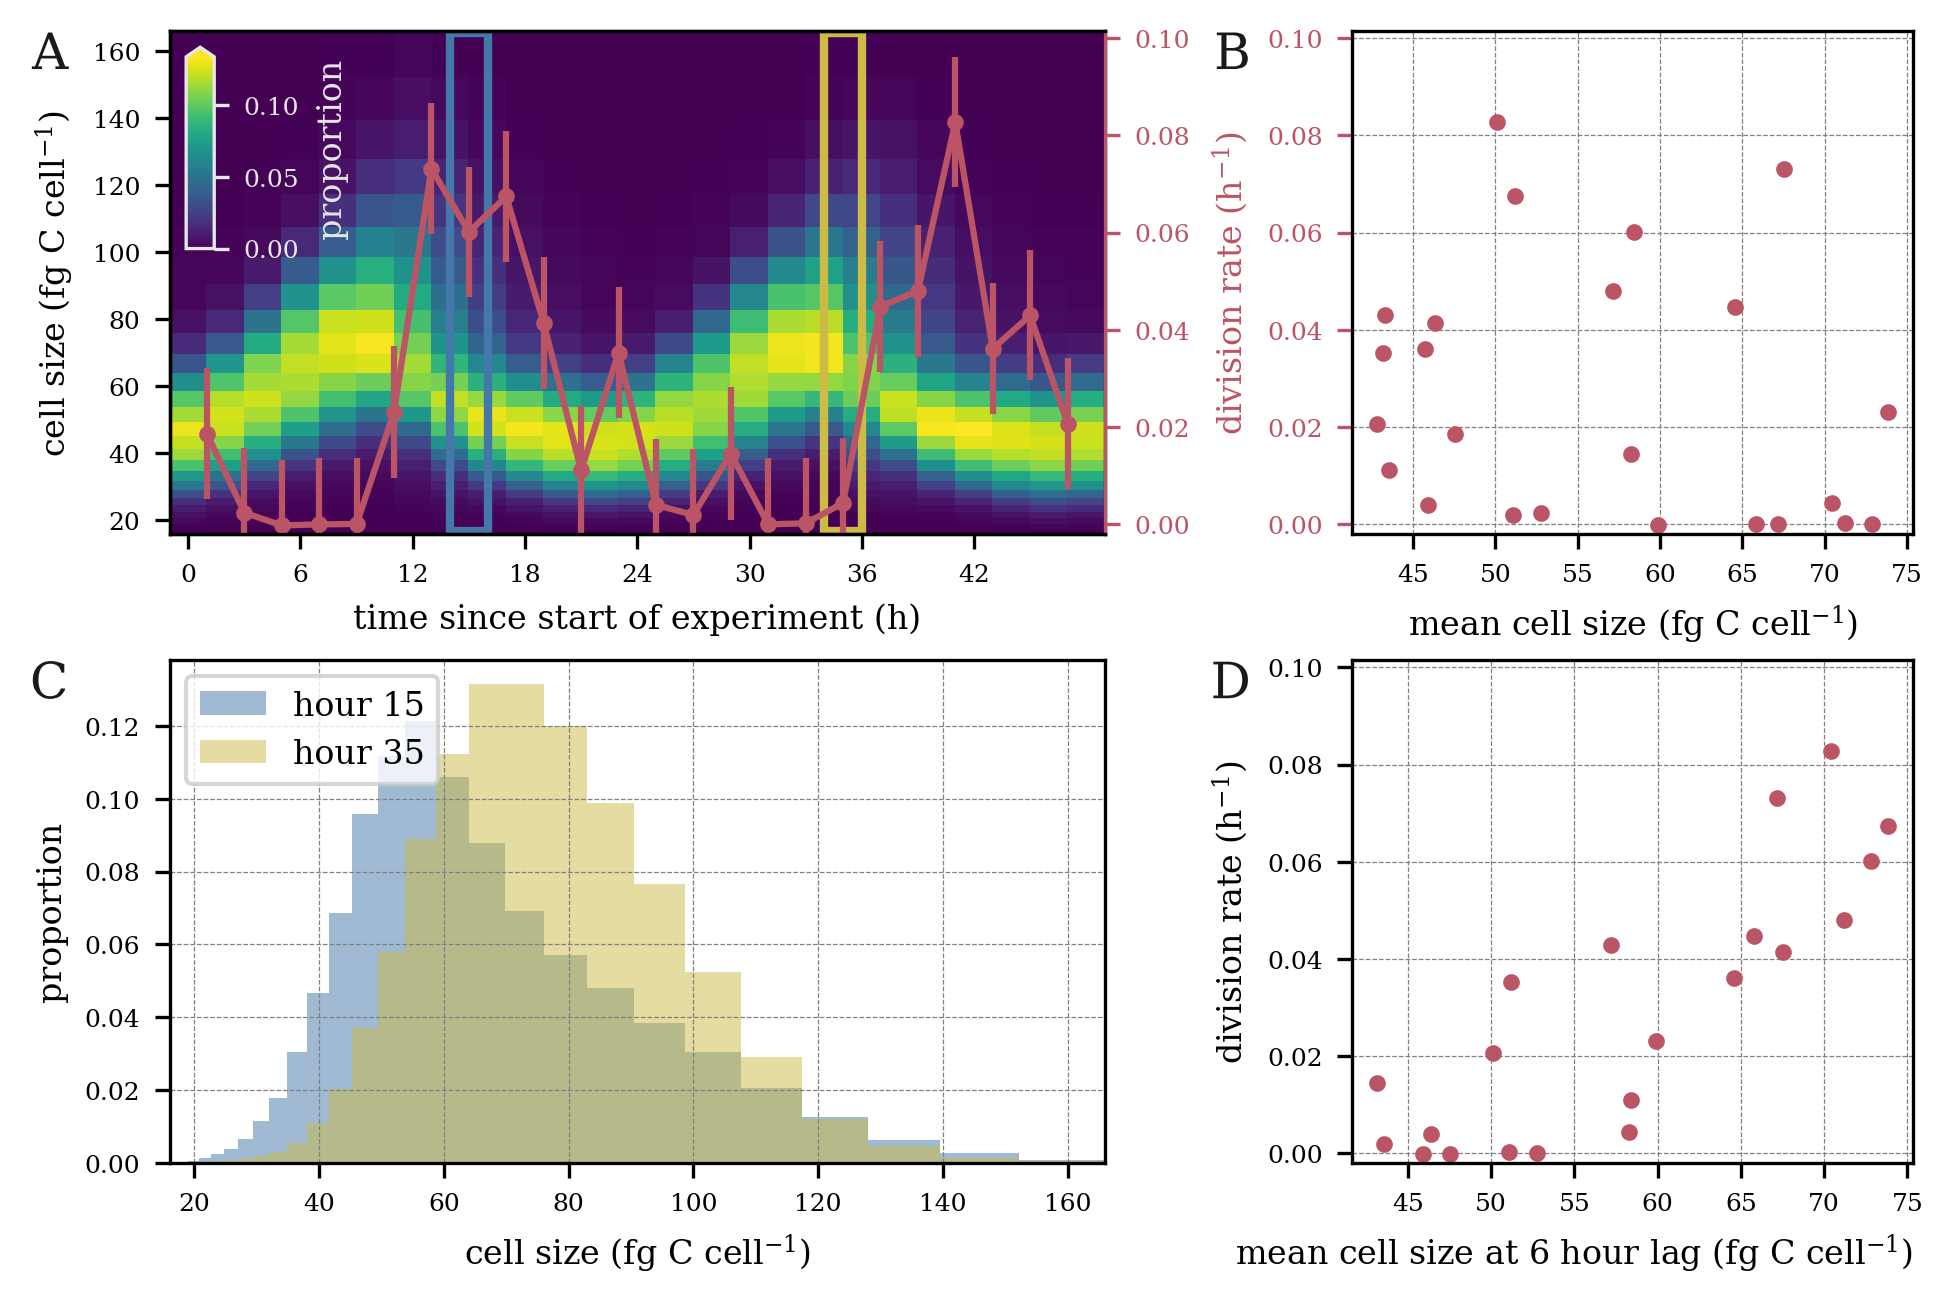

In [13]:
# these determine what gets marked
indices=(7, 17)

colors = ['#4477aa', '#ccbb44']
        
size_bound_centers  = 0.5 * (size_bound_edges[1:] + size_bound_edges[:-1])

units = 'h'

#
# plotting
#

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 5), squeeze=False, gridspec_kw={'hspace':0.25, 'wspace':0.33, 'width_ratios':(2,1.2)})    

def add_colorbar(ax, label=None, labelcolor='0.9', **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='40%', loc='upper left', bbox_to_anchor=(0.0,0.0,1,1), bbox_transform=ax.transAxes)
    cb = mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)
    cb.set_label(label, color=labelcolor)
    for ytl in cb.ax.get_yticklabels():
        ytl.set_color(labelcolor)
    cb.ax.tick_params(axis='y', colors=labelcolor)
    cb.outline.set_edgecolor(labelcolor)

ax_celldist = axs[0,0]
ax_distsclices = axs[1,0]
ax_scatter = axs[0,1]
ax_scatter_offset = axs[1,1]

#
# pcolor
#

if ax_celldist is not None:

    ax = ax_celldist

    tmp = data_gridded[dataname]['w_obs']
    label = 'proportion'

    norm = mpl.colors.Normalize(vmin=0.0)
    pc = ax.pcolormesh(t_edges, size_bound_edges, tmp, norm=norm, rasterized=True)

    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label=label, extend='max')
    #ax.text(0.02, 0.98, 'observations', ha='left', va='top', color='white', transform=ax.transAxes)

    ax.set(xlabel='time since start of experiment ({})'.format(units),
           ylabel=prop_labels['size'])

    ax_div = ax.twinx()
    prop = 'division'
    ax_div.errorbar(ground_truth['division_time'], ground_truth['division'],
                    yerr=ground_truth['division_sd'], color=prop_colors[prop],
                    marker='o', label='division')

    ax.set_xticks(np.arange(0,48,6))
    dt = t[1] - t[0]
    ax.set_xlim((t[0] - 0.5 * dt, t[-1] + 0.5 * dt))

    #ax_div.set_ylabel(prop_labels['division'], color=prop_colors[prop])
    ax_div.tick_params(axis='y', colors=prop_colors[prop])
    ax_div.spines['right'].set_color(prop_colors[prop])
    ax_div.set_ylim(bottom=-0.002) # to allow markers to appear fully
    for ytl in ax_div.get_yticklabels():
        ytl.set_color(prop_colors[prop])

    # set markers
    for index, color in zip(indices, colors):
        print('at index {0:2d}: marking {2}{1} to {3}{1}'.format(index, units, t[index], t[index+1]))
        rect = mpl.patches.Rectangle((t[index],0.005), width=t[1]-t[0], height=1-2*0.005, lw=2, 
                                     fc='none', ec=color, transform=ax.get_xaxis_transform())
        ax.add_artist(rect)

#
# distributions
#

if ax_distsclices is not None:

    ax = ax_distsclices

    for index, color in zip(indices, colors):
        print('index {0:2d}: averaging from {2}{1} to {3}{1}'.format(index, units, t[index], t[index+1]))
        width = size_bound_edges[1:] - size_bound_edges[:-1]
        ax.bar(x=size_bound_edges[:-1], width=width,
               height=np.mean(data_gridded[dataname]['w_obs'][:,index:index+1], axis=1),
               align='edge', label='hour {:.0f}'.format(t_edges[index+1]), color=color, alpha=0.5)

#     ax.set_xscale('log')
    # reset ticks from log-scale
#     ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#     ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

    ax.set_xlim((size_bound_edges[0], size_bound_edges[-1]))
    ax.set_xticks(np.linspace(20, 160, 8))
    ax.set_xticks([], minor=True)
    ax.set_xticklabels([], minor=True)

    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set(xlabel=prop_labels['size'], ylabel='proportion')

#
# scatter
#

for iax, ax in enumerate((ax_scatter, ax_scatter_offset)):

    obs_timeinterp = 0.5 * (data_gridded[dataname]['w_obs'][:,1:] + data_gridded[dataname]['w_obs'][:,:-1])

    x_data = np.sum(size_bound_centers) * np.average(obs_timeinterp, weights=size_bound_centers, axis=0)
    y_data = ground_truth['division']
    y_err = ground_truth['division_sd']
    if iax == 1:
        # could use np.roll
        x_data = x_data[:-3]
        y_data = y_data[3:]
        y_err = y_err[3:]

    ax.plot(x_data, y_data, color=prop_colors[prop], ls='none', marker='o')
    #ax.errorbar(x_data, y_data, yerr=y_err, color=prop_colors[prop], ls='none', marker='o')

    ax.grid(True)
    ax.set(ylim=ax_div.get_ylim(), xlabel='mean '+prop_labels['size'])
    if iax == 0:
        ax.set_ylabel(prop_labels[prop], color=prop_colors[prop])
        for ytl in ax.get_yticklabels():
            ytl.set_color(prop_colors[prop])
        ax.tick_params(axis='y', colors=prop_colors[prop])
    else:
        ax.set_ylabel(prop_labels[prop])
        ax.set_xlabel('mean cell size at 6 hour lag ({}'.format(prop_labels['size'].split('(')[1]), horizontalalignment='right', x=1)

#
# additions
#

path_effects=[pe.withStroke(linewidth=2,foreground='white',alpha=0.75)]

for iax, ax in enumerate(axs.flat):
    points = ax.get_subplotspec().get_position(fig).get_points()
    x = points[0,0] - 0.045
    y = points[1,1]

    fig.text(x, y, 'ABCDEFG'[iax], size=12, ha='right', va='top', color='0.1', path_effects=path_effects)

if save_plots:
    plt.savefig('figures_test/division_vs_size.pdf', bbox_inches='tight', dpi=300)

### plot `fig:model_score`

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


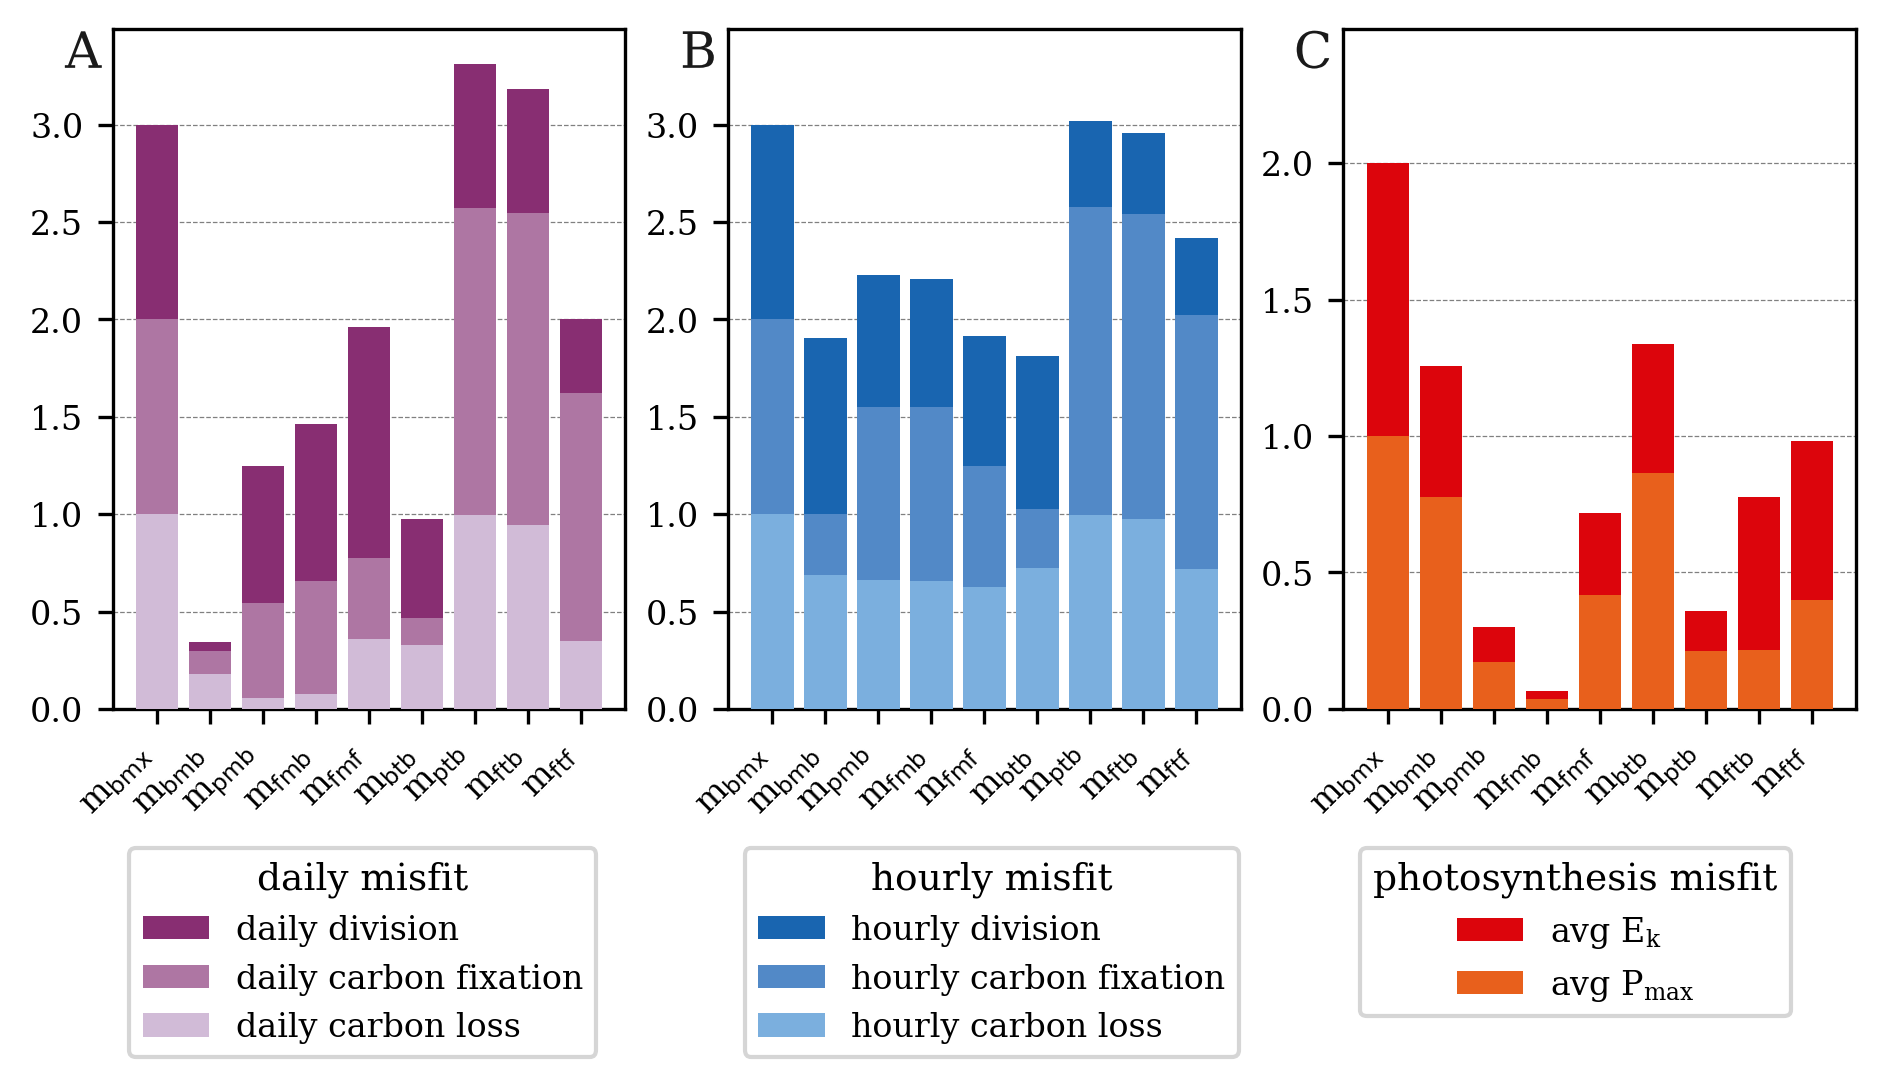

In [14]:
figsize = (7.5, 3)
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

# markersize for scatter plot
scattermarkersize = 15
# and font size for the labels
scatterfontsize = 8

misfit_data = pd.read_csv('data/model_misfit.csv')

# choose from 
# 'size distribution misfit', 'daily carbon loss', 
# 'daily carbon fixation', 'daily division',
# 'hourly carbon loss', 'hourly carbon fixation', 'hourly division',
# 'hourly abundance', 'avg P$_{max}$', 'avg E$_k$'

props = ['daily carbon loss', 'daily carbon fixation', 'daily division',
         'hourly carbon loss', 'hourly carbon fixation', 'hourly division',
         'avg P$_{max}$', 'avg E$_k$']

# select rowindex of model to normalize by 
irow_normalize = 0

colors_prop = {
    'daily carbon loss':'#D1BBD7', 
    'daily carbon fixation':'#AE76A3', 
    'daily division':'#882E72',
    'hourly carbon loss':'#7BAFDE', 
    'hourly carbon fixation':'#5289C7', 
    'hourly division':'#1965B0',
    'hourly abundance':'#F1932D', 
    'avg P$_{max}$':'#E8601C', 
    'avg E$_k$':'#DC050C'
}

#
# plotting
#

# fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=figsize, sharey=True, gridspec_kw={'wspace':0.075})
fig, axs = plt.subplots(ncols=3, figsize=figsize)

# ax = axs[0,0]
# ax_bar = axs[0,1]

# #
# # scatter
# #

# for irow, model_name in enumerate(misfit_data['model name']):
#     x = misfit_data['size distribution misfit'][irow]
#     y = np.sum([misfit_data[prop][irow]/misfit_data[prop][irow_normalize] for prop in props])
    
#     # used to keep each label on top of each marker
#     zorder = 2 + 0.01 * irow
#     ax.plot(x, y, marker='o', ls='none', ms=scattermarkersize, color=colors_model[model_name], 
#             zorder=zorder, label=desc_model[model_name])
    
#     subscript = desc_model[model_name].split('{')[1].strip('${}')
#     if irow in (0, 3, 7):
#         color = '0.9'
#     else:
#         color = '0.1'
#     ax.text(x, y, subscript, va='center', ha='center', size=scatterfontsize, color=color, zorder=zorder+0.005)

#
# bars
#
    
x = np.arange(len(misfit_data['model name']))
width = 0.8
bottom = np.zeros(x.size)
old_type = None
jj = 0
kk = 0
ax_bar = axs[jj]
for i, prop in enumerate(props):
    new_type = re.split(' ', prop)[0]
    if old_type != new_type:
        if old_type:
            ax_bar.set(xticks=x)
            ax_bar.set_xticklabels([desc_model[model_name] for model_name in misfit_data['model name']], size=8,
                       rotation=45, ha='right')
            ax_bar.grid(axis='y')
            handles, labels = ax_bar.get_legend_handles_labels()
            legendargs = {'loc': 'upper left', 'bbox_to_anchor': (0, -0.18)}
            ax_bar.legend(handles[::-1], labels[::-1], title=old_type+' misfit', **legendargs)
            ax_bar.set_ylim(bottom=0, top=kk+0.49)
        ax_bar = axs[jj]
        jj += 1
        bottom = np.zeros(x.size)
        kk = 0
    kk += 1
    old_type = new_type
    height = misfit_data[prop]/misfit_data[prop][irow_normalize]
    ax_bar.bar(x=x, height=height, width=width, bottom=bottom, label=prop, color=colors_prop[prop], zorder=3)
    bottom += height
    
ax_bar.set(xticks=x)
ax_bar.set_xticklabels([desc_model[model_name] for model_name in misfit_data['model name']], size=8,
           rotation=45, ha='right')
ax_bar.grid(axis='y')
handles, labels = ax_bar.get_legend_handles_labels()
legendargs = {'loc': 'upper left', 'bbox_to_anchor': (0, -0.18)}
ax_bar.legend(handles[::-1], labels[::-1], title='photosynthesis'+' misfit', **legendargs)
ax_bar.set_ylim(bottom=0, top=kk+0.49)


#legendargs = {'loc':'best', 'bbox_to_anchor':(0.03, 0.55)} # left of first bar


#
# additions
#

# ax.legend()
# ax.set(xlabel='size distribution misfit', ylabel='sum of model misfit contributions')
# ax.grid(True)

path_effects=[pe.withStroke(linewidth=2,foreground='white',alpha=0.75)]
for iax, ax in enumerate(axs.flat):
    points = ax.get_subplotspec().get_position(fig).get_points()
    x = points[0,0] - 0.005
    y = points[1,1]

    fig.text(x, y, 'ABCDEFG'[iax], size=12, ha='right', va='top', color='0.1', path_effects=path_effects)

if save_plots:
    plt.savefig('figures_test/model_score.pdf', bbox_inches='tight', dpi=300)


### plot `fig:zinser_paramhist`

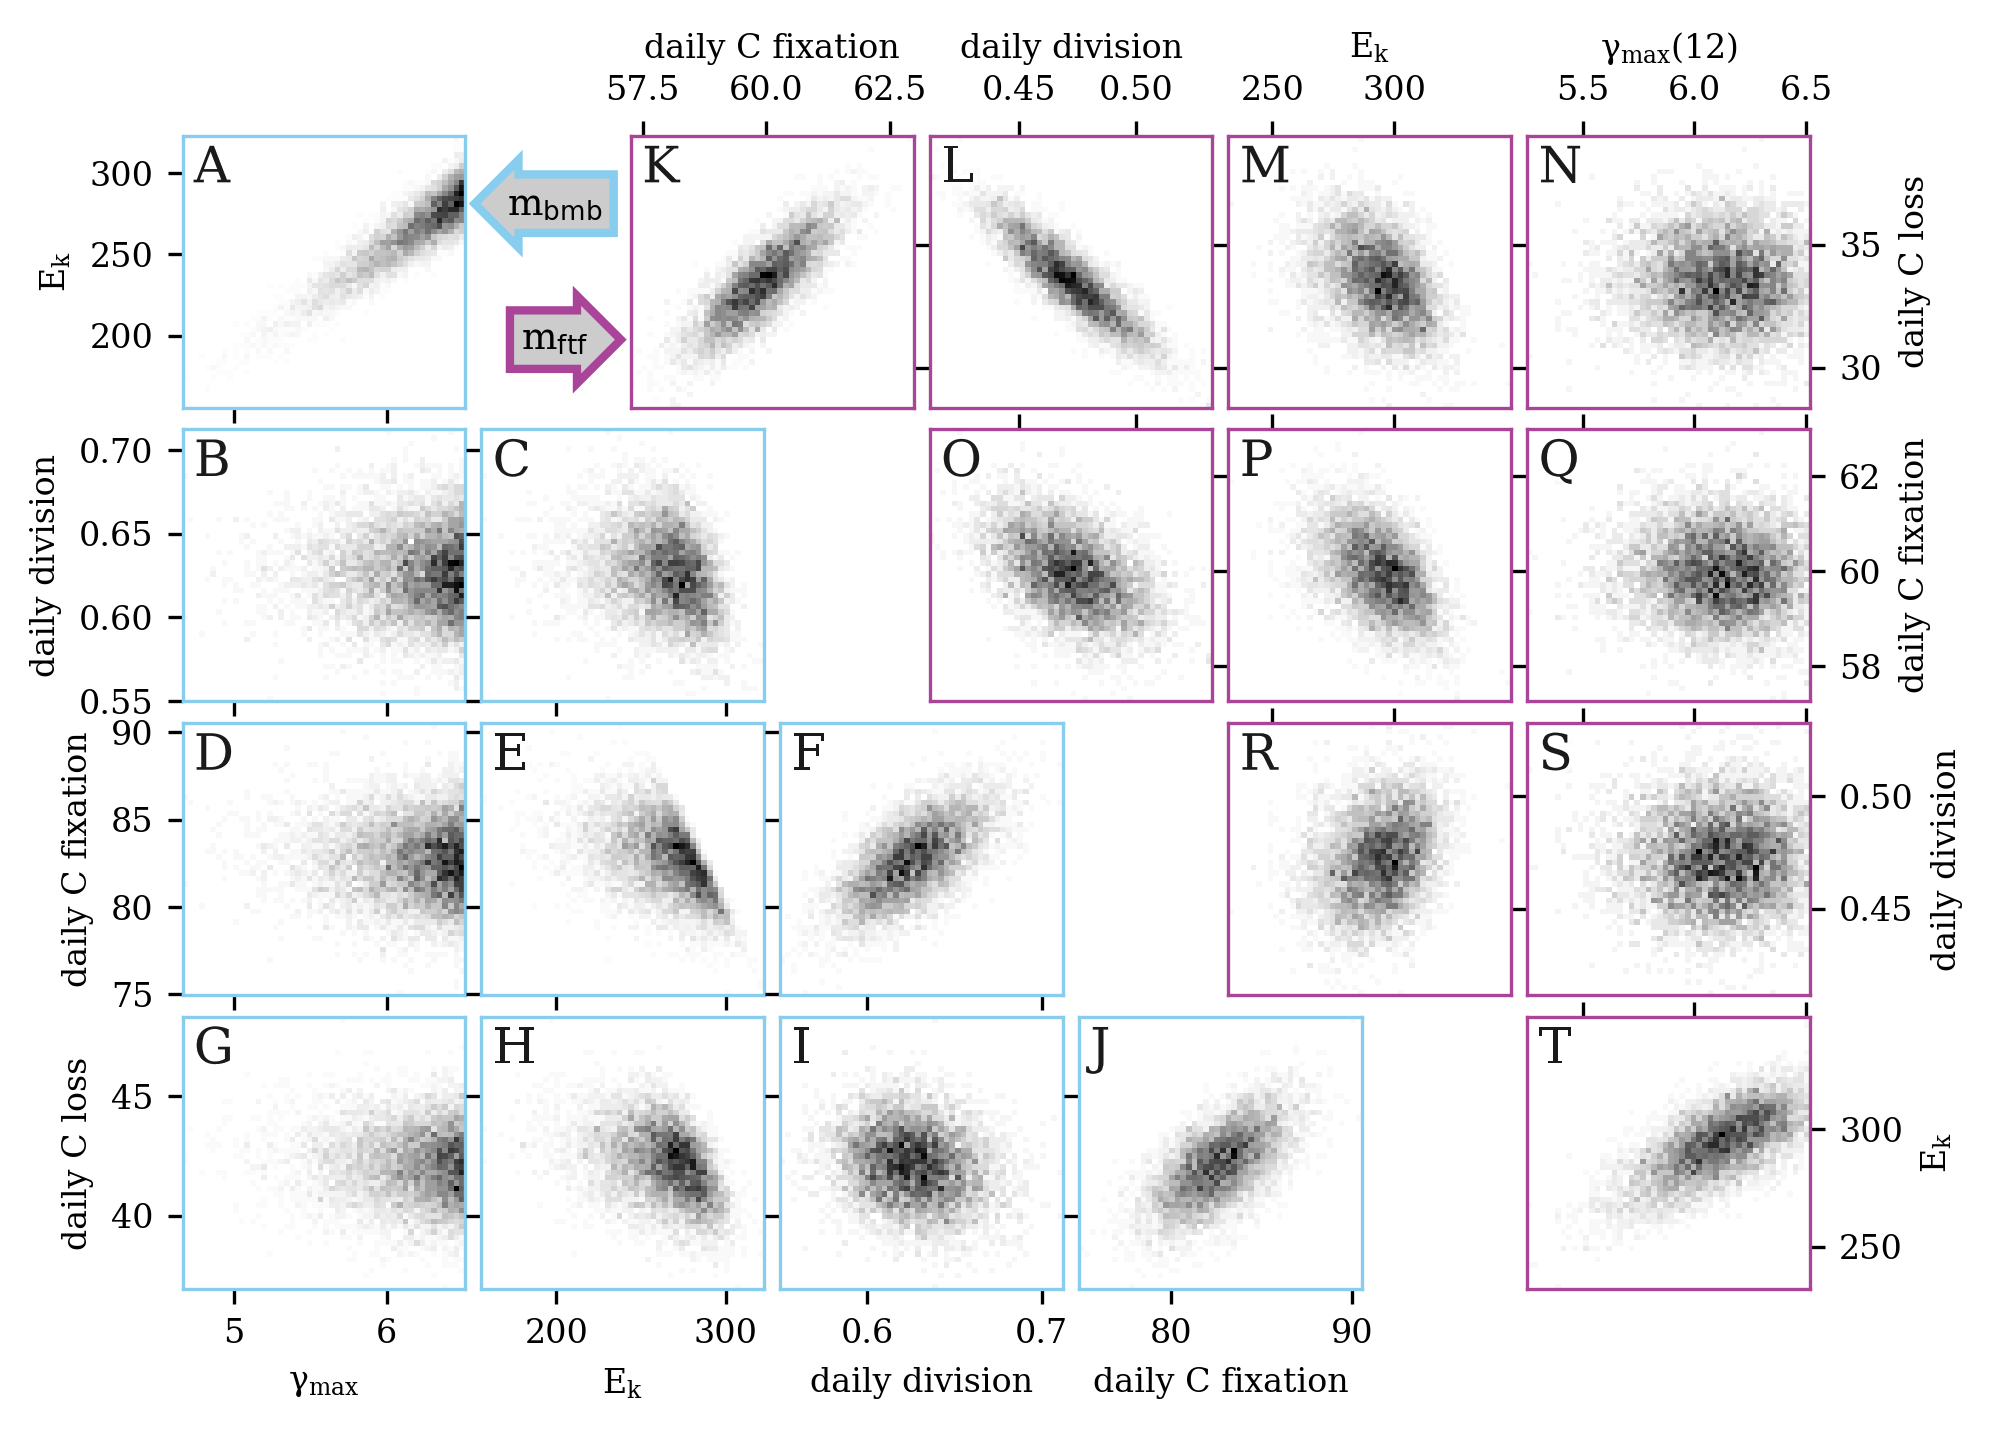

In [15]:
#
# setup
#

datafiles = ('data_exp_zs_20210105_g3_zinser-53fg.nc', 'data_exp_zs_20210105_g3_zinser-53fg.nc')
model_names = ('m4', 'm16s6')

parameter_desc = {
    'E_star':'E$_k$',
    'divrate':'daily division',
    'daily growth':'daily C fixation',
    'daily loss':'daily C loss',
    'gamma_max':'$\\gamma_{max}$',
    'rho_max':'$\\rho_{max}$',
    'delta_max':'$\\delta_{max}$',
    'gamma_mu':'$\\mu_{\\gamma}$',
    ('gamma_max',11):'$\\gamma_{max}(12)$',
}

paramnames = {'m4': ['gamma_max', 'E_star', 'divrate', 'daily growth', 'daily loss'], 
              'm16s6':['daily loss', 'daily growth', 'divrate', 'E_star', ('gamma_max',11)]}

data_name = 'zinser'

#
# helper functions
#

def integrate(sample, time):
    dt = np.diff(time)
    return 0.5 * np.sum(dt * (sample[...,1:] + sample[...,:-1]), axis=-1)


def extract_growth(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    if 'growth_vol_gain' in nc_model.variables:
        growth_size_gain = nc_model.variables['growth_vol_gain'][:]
    else:
        growth_size_gain = nc_model.variables['growth_size_gain'][:]
    # units: fg C cell^-1 h^-1
    growth = growth_size_gain/cell_count/dt_h
    if compute_int:
        return integrate(growth, model_time_hours), model_time_hours[-1] - model_time_hours[0]
    return growth, model_time_hours
    

def extract_loss(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    if 'resp_vol_loss' in nc_model.variables:
        resp_size_loss = nc_model.variables['resp_vol_loss'][:]
    else:
        resp_size_loss = nc_model.variables['resp_size_loss'][:]
    # units: fg C cell^-1 h^-1
    loss = resp_size_loss/cell_count/dt_h
    if compute_int:
        return integrate(loss, model_time_hours), model_time_hours[-1] - model_time_hours[0]
    return loss, model_time_hours


#
# extract data
#

plotdata = {model_name:{} for model_name in model_names}

for datafile, model_name in zip(datafiles, model_names):
    with nc4.Dataset(datafile) as nc:
        ncg = nc.groups[data_name]
        #plotdata[exp]['i_test'] = ncg.variables['i_test'][:].astype('bool')
        #obs = ncg.variables['obs'][:].data

        if model_name not in ncg.groups:
            raise ValueError('Cannot find model "{}" in data file "{}".'.format(model_name, datafile))

        ncm = ncg.groups[model_name]

        model_time_hours = ncg.variables['time'][:].data / 60

        for paramname in paramnames[model_name]:
            if paramname == 'daily growth':
                plotdata[model_name][paramname] = extract_growth(ncg.groups[model_name], 
                                                                 model_time_hours=model_time_hours, 
                                                                 compute_int=True)[0]/((model_time_hours[-1]-model_time_hours[0])/24)
            elif paramname == 'daily loss':
                plotdata[model_name][paramname] = extract_loss(ncg.groups[model_name], 
                                                               model_time_hours=model_time_hours, 
                                                               compute_int=True)[0]/((model_time_hours[-1]-model_time_hours[0])/24)
            elif isinstance(paramname, tuple):
                plotdata[model_name][paramname] = ncm.variables[paramname[0]][:,paramname[1]].data
            else:
                plotdata[model_name][paramname] = ncm.variables[paramname][:].data

# turn it into a function that can be called again below
def create_matrixplot(raw_plot=False):
    if raw_plot:
        for imodel, model_name in enumerate(model_names): 
            num_params = len(paramnames[model_name])

            fig, axs = plt.subplots(num_params-1, num_params-1, sharex='col', sharey='row', 
                                    figsize=(12,12), squeeze=False)


            for ax in axs.flat:
                ax.set_visible(False)
            for irow in range(1,num_params):
                for icol in range(irow):
                    ax = axs[irow-1,icol]
                    ax.set_visible(True)
                    xname = paramnames[model_name][icol]
                    yname = paramnames[model_name][irow]

                    xdata = plotdata[model_name][xname]
                    ydata = plotdata[model_name][yname]

                    ax.hist2d(xdata, ydata, bins=50, cmap=mpl.cm.gray_r)
                    if icol == 0:
                        ax.set_ylabel(yname)
                    if irow == num_params-1:
                        ax.set_xlabel(xname)

    else:
        assert len(paramnames[model_names[0]]) == len(paramnames[model_names[1]])

        n = len(paramnames[model_names[0]])

        width = 7

        # shape: (n-1, n+0.5)
        fig = plt.figure(figsize=(width, width/(n+0.5)*(n-1)))

        gs = mpl.gridspec.GridSpec((n-1), 2*n+1)
        gs.update(wspace=0.12, hspace=0.08)

        # this will be a list of arrays
        axs = []

        for imodel, model_name in enumerate(model_names):
            axs.append(np.empty(shape=(n-1, n-1), dtype=object))

        for irow in range(n-1):
            for icol in range(n):
                if irow >= icol:
                    # bottom right
                    axs[0][irow, icol] = plt.subplot(gs[irow, 2*icol:2*(icol+1)])
                else:
                    axs[1][irow, icol-1] = plt.subplot(gs[irow, 2*icol+1:2*(icol+1)+1])


        model_name = model_names[0]
        num_params = len(paramnames[model_name])

        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[0][irow-1,icol]

                xname = paramnames[model_name][icol]
                yname = paramnames[model_name][irow]

                xdata = plotdata[model_name][xname]
                ydata = plotdata[model_name][yname]

                ax.hist2d(xdata, ydata, bins=50, cmap=mpl.cm.gray_r, rasterized=True)
                if icol == 0:
                    ax.set_ylabel(parameter_desc[yname])
                else:
                    ax.set_yticklabels([])
                if irow == num_params-1:
                    ax.set_xlabel(parameter_desc[xname])
                else:
                    ax.set_xticklabels([])


        model_name = model_names[1]
        num_params = len(paramnames[model_name])


        for icol in range(1,num_params):
            for irow in range(icol):
                ax = axs[1][irow,icol-1]

                xname = paramnames[model_name][icol]
                yname = paramnames[model_name][irow]

                xdata = plotdata[model_name][xname]
                ydata = plotdata[model_name][yname]

                #ax.yaxis.tick_right()
                #ax.xaxis.tick_top()
                ax.tick_params(left=False, labelleft=False, right=True, labelright=True)
                ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)

                ax.hist2d(xdata, ydata, bins=50, cmap=mpl.cm.gray_r, rasterized=True)
                if icol == num_params-1:
                    ax.set_ylabel(parameter_desc[yname])
                    ax.yaxis.set_label_position('right')
                else:
                    ax.set_yticklabels([])
                if irow == 0:
                    ax.set_xlabel(parameter_desc[xname])
                    ax.xaxis.set_label_position('top')
                else:
                    ax.set_xticklabels([])


        #
        # add arrows
        #

        ax_label = plt.subplot(gs[0, 2:3])

        ax_label.set(xticks=[], yticks=[])

        bbox_props = {'boxstyle':'rarrow,pad=0.3', 'fc':'0.8', 'ec':colors_model[model_name], 'lw':2}
        for imodel, model_name in enumerate(model_names):
            bbox_props['ec'] = colors_model[model_name]
            if imodel == 0:
                bbox_props['boxstyle'] = 'larrow,pad=0.3'
            else:
                bbox_props['boxstyle'] = 'rarrow,pad=0.3'

            ax_label.text(0.55, 0.75 - imodel * 0.5, desc_model[model_name], 
                          ha='center',
                          va='center',
                          rotation=0,
                          transform=ax_label.transAxes,
                          bbox=bbox_props)
        ax_label.set_axis_off()

        #
        # add colored spines and labels
        #

        for imodel, model_name in enumerate(model_names):
            for ax in axs[imodel].flat:
                if ax is not None:
                    for key in ax.spines:
                        ax.spines[key].set_color(colors_model[model_name])


        path_effects=[pe.withStroke(linewidth=2, foreground='white', alpha=0.75)]

        ilabel = -1
        for imodel, model_name in enumerate(model_names):
            for ax in axs[imodel].flat:
                if ax is not None:
                    ilabel += 1
                    ax.text(0.04, 0.97, '{}'.format('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[ilabel]), size=12, ha='left', va='top', color='0.1', transform=ax.transAxes, path_effects=path_effects)
    return fig, axs

fig = create_matrixplot()[0]

if save_plots:
    fig.savefig('figures/parammatrixplot.pdf', bbox_inches='tight', dpi=300)

### same as above but with equalized axes

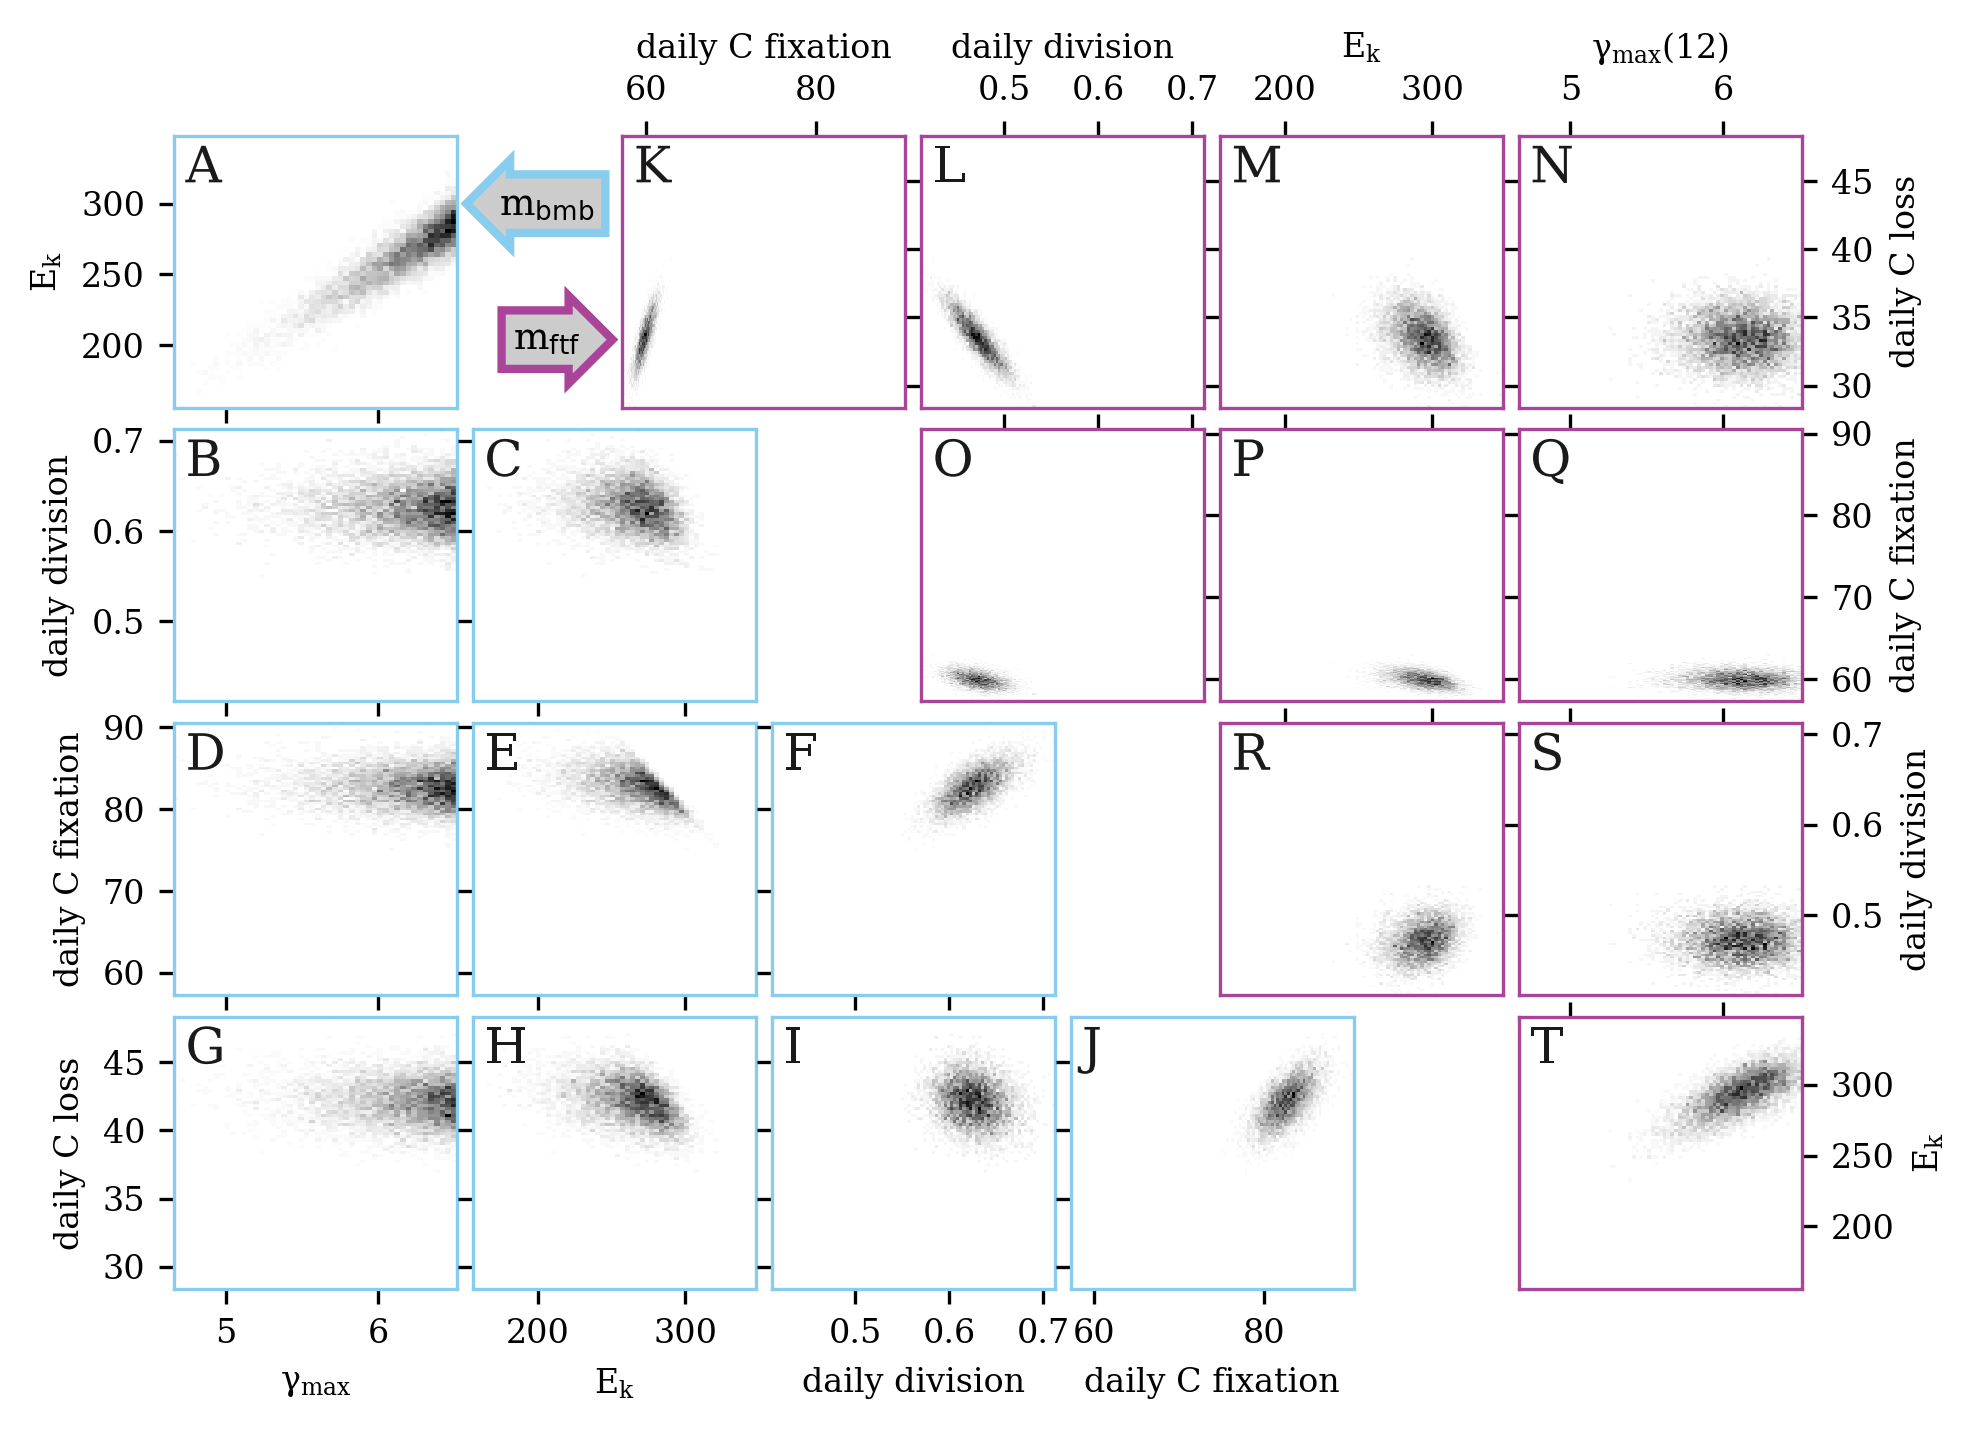

In [16]:
fig, axs = create_matrixplot()

# read entries ((0,1), (3,2)) as:
# equalize ylim or row 0 and xlim of column 1 in axs[0] with
#          ylim of row 3 and xlim of column 2 in axs[1]
equalize = (
    ((0,1), (3,2)),
    ((1,2), (2,1)),
    ((2,3), (1,0)),
    ((3,None), (0,None)),
    ((None,0), (None,3)),
)

for e0, e1 in equalize:
    if e0[0] is None:
        lim0 = axs[0][-1,e0[1]].get_xlim()
    else:
        lim0 = axs[0][e0[0],0].get_ylim()
    if e1[1] is None:
        lim1 = axs[1][e1[0],-1].get_ylim()
    else:
        lim1 = axs[1][0,e1[1]].get_xlim()
    lim = (min(lim0[0], lim1[0]), max(lim0[1], lim1[1]))
    
    for iax, e in enumerate((e0, e1)):
        irow = e[0]
        if irow is not None:
            for icol in range(axs[iax].shape[1]):
                if axs[iax][irow,icol] is not None:
                    axs[iax][irow,icol].set_ylim(lim)
        icol = e[1]
        if icol is not None:
            for irow in range(axs[iax].shape[0]):
                if axs[iax][irow,icol] is not None:
                    axs[iax][irow,icol].set_xlim(lim)

if save_plots:
    fig.savefig('figures/parammatrixplot_rescaled.pdf', bbox_inches='tight', dpi=300)

### plot `fig:xval`

In [17]:
#
# setup
#

datafiles = {
    'ref':('data_exp_zs_20210105_g3_zinser-53fg.nc',),
    'expA':('data_exp_zs_20210105_g3_zinser-53fg-itest.nc',),
    'expB':('data_exp_zs_20210105_g3_zinser-53fg-itestday1.nc',),
    'expC':('data_exp_zs_20210105_g3_zinser-53fg-itest-keepeverythird.nc',),
}
parameters = {'divrate':'m4', 'E_star':'m12u', 'daily growth':'m12u'}
data_name = 'zinser'
exp_names = {'ref':'full data', 'expA':'experiment A', 'expB':'experiment B', 'expC':'experiment C'}
parameter_desc = {'E_star':'E$_k$', 'divrate':'daily div.', 'daily growth':'daily C fix.'}

add_violinlabels = True

model_names = mod_list

#
# get data
#

plotdata = {}

for exp in datafiles:
    plotdata[exp] = {}

    plotdata[exp]['misfit'] = {}
    plotdata[exp]['parameters'] = {}

    for datafile in datafiles[exp]:
        with nc4.Dataset(datafile) as nc:
            ncg = nc.groups[data_name]
            plotdata[exp]['i_test'] = ncg.variables['i_test'][:].astype('bool')
            obs = ncg.variables['obs'][:].data

            for model_name in model_names:
                if model_name not in ncg.groups:
                    continue
                    #raise ValueError('Cannot find model "{}" in data file "{}".'.format(model_name, datafiles[exp][0]))
                mod = ncg.groups[model_name].variables['mod_obspos'][:].data
                mod /= np.sum(mod, axis=1)[:,None,:]

                # sum across size class
                e = np.sum((mod-obs[None,:,:])**2, axis=1)

                plotdata[exp]['misfit'][model_name] = np.array((
                    np.mean(np.mean(e, axis=1)),
                    np.mean(np.mean(e[:, plotdata[exp]['i_test'] == 0], axis=1)),
                    np.mean(np.mean(e[:, plotdata[exp]['i_test'] == 1], axis=1)),
                ))

                plotdata[exp]['parameters'][model_name] = {}
                for p in parameters:
                    if model_name == parameters[p]:
                        if p == 'daily growth':
                            model_time_hours = ncg['time'][:]/60
                            #print((model_time_hours[-1]-model_time_hours[0])/24)
                            plotdata[exp]['parameters'][model_name][p] = extract_growth(ncg.groups[model_name], model_time_hours=model_time_hours, compute_int=True)[0]/((model_time_hours[-1]-model_time_hours[0])/24)
                        else:
                            plotdata[exp]['parameters'][model_name][p] = ncg.groups[model_name].variables[p][:].data

#
# helper functions
#

def violinplot(ax, dataset, color=None, linewidth=None, **violinplotargs):
    parts = ax.violinplot(dataset, **violinplotargs)
    
    for part in parts:
        if part == 'bodies':
            for pc in parts[part]:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
        else:
            parts[part].set_color(color)
    
    if linewidth is not None:
        parts['cbars'].set_linewidth(linewidth)
        parts['cmins'].set_linewidth(linewidth)
        parts['cmaxes'].set_linewidth(linewidth)
    return parts

#
# plotting
#

num_bars = 2
num_data = len(datafiles) - 1
num_params = len(parameters)

fig = plt.figure(figsize=(7, 2 + 1.5*num_data))
axs_bar = np.empty(shape=num_data, dtype=object)
axs_params = np.empty(shape=num_params, dtype=object)

gs_bar = mpl.gridspec.GridSpec(num_data, 1)
gs_bar.update(bottom=0.38, hspace=0.04)

gs_params = mpl.gridspec.GridSpec(1, num_params)
gs_params.update(top=0.32, left=0.09)

for i in range(num_data):
    axs_bar[i] = plt.subplot(gs_bar[i,0])
for i in range(num_params):
    axs_params[i] = plt.subplot(gs_params[0,i])

#
# violin plots
#

positions = np.arange(num_data+1)

for p, ax in zip(parameters, axs_params):

    model_name = parameters[p]

    violinplot(ax, [plotdata[exp]['parameters'][model_name][p] for exp in datafiles], 
               positions=positions, color=colors_model[model_name])
    ax.grid(axis='y', zorder=0)
    ax.set(xticks=[])

    if add_violinlabels:
        for iexp, exp in enumerate(datafiles):
            ax.text(positions[iexp]-0.5, 0.1, exp_names[exp], transform=ax.get_xaxis_transform(), rotation=90, ha='center', va='bottom', size=mpl.rcParams['xtick.labelsize'])
        ax.set_xlim(left=-0.7)
    ylim = ax.get_ylim()
    ax.set_ylim(top = ylim[1] + 0.2 * (ylim[1] - ylim[0]))

#
# bar plots
#

xticks = []
xticklabels = []
gap = 0.7

iax = -1
for exp in datafiles:
    if exp == 'ref':
        continue

    iax += 1
    ax = axs_bar[iax]

    for i,model_name in enumerate(model_names):

        height = plotdata[exp]['misfit'][model_name][-num_bars:]

        x = (num_bars+gap)*i + np.arange(num_bars)
        # zorder = 3 to move in front of bars
        ax.bar(x=x, height=height, color=colors_model[model_name], zorder=3)
        if i == 0:
            for xx, text in zip(x, ['training','testing']):
                ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', color='white')
        xticks.append(np.mean(x))
        xticklabels.append(desc_model[model_name].replace(',',',\n').replace('(','\n('))

        ax.set(xticks=xticks, xticklabels=[])#, rotation=8)
        ax.grid(axis='y')

    axins_cbar = inset_axes(ax, width='40%', height='10%', loc='upper right', bbox_to_anchor=(0.0,0.0,1,1), 
                            bbox_transform=ax.transAxes)
    axins_cbar.set(xticks=[], yticks=[])
    axins_cbar.pcolormesh(np.arange(len(plotdata[exp]['i_test'])+1), [0, 1], plotdata[exp]['i_test'][None,:], 
                          vmin=0, vmax=1, cmap=mpl.cm.Greys)

if num_data % 2 == 1:
    axs_bar[num_data//2].set_ylabel('size distribution misfit')
else:
    axs_bar[num_data//2-1].set_ylabel('size distribution misfit', horizontalalignment='right', x=1)

axs_bar[-1].set_xticklabels(xticklabels, size=mpl.rcParams['font.size'])

# equalize axes
ylim_top = 0
for ax in axs_bar:
    ylim_top = max(ylim_top, ax.get_ylim()[1])
if ylim_top < 0.009:
    ylim_top = 0.009

for ax in axs_bar:
    ax.set_ylim(top=ylim_top)

#
# add labels
#
    
path_effects=[pe.withStroke(linewidth=2, foreground='white', alpha=0.75)]
ilabel = -1
for ax in axs_bar.flat:
    ilabel += 1
    ax.text(0.01, 0.98, 'ABCDEFG'[ilabel], size=12, ha='left', va='top', color='0.1', transform=ax.transAxes, path_effects=path_effects)

iax = -1
for ax, p in zip(axs_params.flat, parameters):
    iax += 1
    ilabel += 1
    ax.text(0.01, 0.98, '{})'.format('ABCDEFG'[ilabel]), size=12, ha='left', va='top', color='0.1', transform=ax.transAxes, path_effects=path_effects)
    ax.text(0.15, 0.98, '{} {}'.format(desc_model[parameters[p]], parameter_desc[p]), ha='left', va='top', color='0.1', transform=ax.transAxes, path_effects=path_effects)

if save_plots:
    fig.savefig('figures/zinser_xval.pdf', bbox_inches='tight', dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: b'data_exp_zs_20210105_g3_zinser-53fg-itest.nc'